# Importy a načtení dat

In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
np.set_printoptions(precision=2)
import scipy.io as sio
from math import erf
from typing import Tuple
import random
import os
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm_notebook

# Import z ModelsCollection (soubor, kde budu ukládat všechny modely pro snazší použití)
import sys
sys.path.append('..')
from ModelsCollection import *

import mat73

import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
dataDictionary = mat73.loadmat("../data/Chernobyl_wildfires2020_data/SRS_data_EU_spatiotemporal_v2.mat")

In [3]:
kovaletsPriorDictionary = mat73.loadmat("../data/Chernobyl_wildfires2020_data/Kovalets_prior/gt.mat")

## Popis dat

- Ms = data (z tohoto vyjde matice X)
- ind_cez = označení Chernobyl Exc. Zone (-> nutné vyhodit pokud ind_cez = 1)
- koefBq = koeficient pro převod výsledku na Bq
- lat/long
- y_orig, y_unc = y původní a jeho *ne*jistota

In [4]:
for key in dataDictionary.keys():
    print(key)

Ms
ind_cez
koefBq
latitudes
longitudes
y_orig
y_unc


In [5]:
# lat lon frakce hladina mereni cas
dataDictionary["Ms"].shape

(11, 11, 3, 7, 858, 30)

## Příprava dat

In [6]:
koefBq = dataDictionary["koefBq"]

Formá dat v rámci `dataDictionary["Ms"]` je postupně: lat lon frakce hladina mereni cas 

In [7]:
def prepData(dataDictionary,dayIntervals):
    tmp = dataDictionary["Ms"]
    indCEZ = dataDictionary["ind_cez"]
    
    # průměr přes všechny částice
    tmp = np.mean(tmp,axis=2)
    # průměr přes všechny výškové hladiny
    tmp = np.mean(tmp,axis=2)
    
    # průměr přes denní intervaly 
    n = len(dayIntervals)
    aggregatedByDays = [np.mean(tmp[:,:,:,interval[0]-1:interval[1]-1],axis=3) for interval in dayIntervals]
    
    # filtrace mimo CEZ
    aggregatedByDays = [aggregate[:,:,dataDictionary["ind_cez"] == 0] for aggregate in aggregatedByDays]
    
    # intervaly dnů, lat, lon, měření
    return np.array(aggregatedByDays)
    
def prepY(dataDictionary):
    # vzít každou 5. hodnotu (Centrální [zanedbání S-J-V-Z])
    y_orig = dataDictionary["y_orig"][range(0,len(dataDictionary["y_orig"]),5)]
    y_unc = dataDictionary["y_unc"][range(0,len(dataDictionary["y_unc"]),5)]
    
    # filtrace mimo CEZ
    return y_orig[dataDictionary["ind_cez"] == 0],y_unc[dataDictionary["ind_cez"] == 0]

In [8]:
dataDictionary["ind_cez"].shape

(858,)

In [9]:
dayIntervals = [(3,8),(8,10),(10,12),(12,14),(16,21)] # intervaly ze článku Talerko et al., 2021a
aggregatedByDaysFiltered = prepData(dataDictionary,dayIntervals)

aggregatedByDaysFiltered.shape

(5, 11, 11, 792)

In [10]:
def createMatrixX(processedDataX):
    latShape = processedDataX.shape[1]
    lonShape = processedDataX.shape[2]
    timeShape = processedDataX.shape[0]

    # time -> lon -> lat
    matrixXOut = np.array([processedDataX[c,b,a,:]  for b in range(latShape) for a in range(lonShape) for c in range(timeShape)]).T
    return matrixXOut

In [11]:
matrixX = createMatrixX(aggregatedByDaysFiltered)
matrixX_scaled = matrixX/koefBq
matrixX.shape

(792, 605)

Matice `matrixX` má formát odpovídající maticím z předchozích benchmarks notebooků. Sloupce tedy odpovídají (postupně od prvního):

- lon\[0\],lat\[0\],cas\[0\]
- ...
- lon\[0\],lat\[0\],cas\[4\]
- lon\[0\],lat\[1\],cas\[0\]
- ...
- lon\[0\],lat\[1\],cas\[4\]
- ...
- lon\[0\],lat\[10\],cas\[4\]
- lon\[1\],lat\[0\],cas\[0\]
- ...

a v každém sloupci je 792 hodnot (měření mimo CEZ)


In [12]:
y_orig,y_unc = prepY(dataDictionary)

In [13]:
y_orig.shape

(792,)

In [14]:
y = y_orig.reshape(-1,1)

In [15]:
# škálování dle toho, zda Beta byla vypočítána s přeškálovanou maticí X či nikoliv
def MSE(betaIn, toScale=False):
    if toScale:
        return np.linalg.norm(y - (matrixX_scaled@betaIn))**2
    return np.linalg.norm(y - (matrixX@betaIn))**2

### Kovalets wildfire preprocess

In [16]:
def getKovaletPrior(keyToGet):
    # získání části keyToGet z kovaletsPriorDictionary aby odpovídala betaHat
    kovaletIn = kovaletsPriorDictionary[keyToGet]

    # lat,long,time
    tmp = np.zeros((11,11,5))

    # suma, protože se jedná o emisi Beta
    for index,interval in enumerate(dayIntervals):
        tmp[:,:,index] = np.sum(kovaletIn[:,:,interval[0]-1:interval[1]-1],axis=2)

    latShape = tmp.shape[0]
    lonShape = tmp.shape[1]
    timeShape = tmp.shape[2]
    
    # time -> lon -> lat
    kovaletOut = np.array([tmp[b,a,c] for b in range(latShape) for a in range(lonShape) for c in range(timeShape)]).reshape(-1,1)
    return kovaletOut

kovaletWildfires = getKovaletPrior("wildfires")
kovaletStorm = getKovaletPrior("storm")
kovaletTotal = getKovaletPrior("total")

# Definice modelů

In [17]:
# poté možná zvednout na 1001
iterCount = 101

## Time (bez úprav)

Matice L odpovídá korelací daného políčka.

In [18]:
# Každý 5. prvek nechá bez korelace
timeModelL = [[i+1] if (i + 1) % 5 != 0 else [] for i in range(0,matrixX.shape[1]-1)]

## Prostorový (bez úprav)

Matice L odpovídá korelaci sousedních políček v daném čase.

In [19]:
def getAdjacentSquares(i):
    adjOut = []
    if (i + 5) // (11 * 5) == (i) // (11 * 5):
        adjOut.append(i+5)
    if i + (11 * 5) < matrixX.shape[1]:
        adjOut.append(i+11*5)
    return adjOut

spaceModelL = [getAdjacentSquares(i) for i in range(0,matrixX.shape[1]-1)]

## Časoprostorový (bez úprav)

Matice L odpovídá korelaci daného políčka v různých časech a sousedních políček v daném čase.

In [20]:
# časový a prostorový model dohromady - brzy se zasekne v lokálním optimu
# spaceAndTimeModelL = []
# for index in range(len(timeModelL)):
#     spaceAndTimeModelL.append(sorted(list(set([*timeModelL[index],*spaceModelL[index]]))))

In [21]:
# alternativní verze časoprostorového modelu - časová informace a zároveň prostor v budoucím čase 
# odpovídá předešlému testovanému modelu
def getAdjacentSquaresSpaceAndTime(i):
    adjOut = []
    if i % 5 == 4:
        return adjOut
    if (i + 5) // (11 * 5) == (i) // (11 * 5):
        adjOut.append(i+5+1)
    if i + (11 * 5) < matrixX.shape[1]:
        adjOut.append(i+11*5+1)
    return adjOut

spaceAndTimeModelL = []
tmpSpace = [getAdjacentSquaresSpaceAndTime(i) for i in range(0,matrixX.shape[1]-1)]
for index in range(len(timeModelL)):
    spaceAndTimeModelL.append(sorted(list(set([*timeModelL[index],*tmpSpace[index]]))))

# Vizualizace

In [22]:
def plotScatterOnAx(ax,betaEstimation,scaleKoefBq=False):
    ax.set_title(f"Bodový graf odhad vs měření")
    ax.set_xlabel("Odhad")
    ax.set_ylabel("Měření")
    
    ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", color="red")
    
    
    # minVal = min(min(matrixX @ betaEstimation),min(y))
    # maxVal = max(max(matrixX @ betaEstimation),max(y))
    if scaleKoefBq:
        ax.scatter(matrixX @ betaEstimation,y)
    else:
        ax.scatter(matrixX_scaled @ betaEstimation,y)
        # minVal = min(min(matrixX_scaled @ betaEstimation),min(y))
        # maxVal = max(max(matrixX_scaled @ betaEstimation),max(y))
    ax.axis("square")
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    valMin = min(x_min, y_min)
    valMax = min(x_max, y_max)
    
    ticks = np.arange(0,valMax,np.floor((valMax+abs(0))//3/50)*50)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
# plotScatter(kovaletTotal,title="Kovalet Total",scaled=True)

In [23]:
def plotReleaseOnAxInnerRegular(ax,betaEstimation,scaleKoefBq=False):
    ax.set_title(f"Únik [GBq] cesia-137 dle času")
    
    ax.set_xlabel("Diskrétní časové okamžiky")
    ax.set_ylabel("Únik [GBq]")
    labels = ["3.–7. 4.","8.–9. 4.","10.–11. 4.","12.–13. 4.","16.–20. 4.", "celý duben"]
    colors = [*["blue" for i in range(len(labels)-1)], "orange"]
    tmp = betaEstimation.reshape(-1,1)
    vals = [np.sum(tmp[i::5,0]) / 1000000000 for i in range(len(labels)-1)]
    vals.append(np.sum(tmp[:,0]) / 1000000000)
    if scaleKoefBq:
        vals = vals * koefBq
    
    bars=ax.bar(labels, vals, color=colors)
    ax.bar_label(bars,fmt="%.0f GBq")
    ax.set_ylim(min(vals) - max(vals) * 0.2, max(vals)* 1.2)
# plotRelease(kovaletTotal,title="Kovalet Total",scaled=True)

In [24]:
def printTotalReleaseUncertaintyInterval(betaEstimation,varianceEstimation,scaleKoefBq=False):
    sdTmp = np.sqrt(varianceEstimation.reshape(-1,1)) / 1000000000
    estTmp = betaEstimation.reshape(-1,1) / 1000000000
    
    if scaleKoefBq:
        estTmp = estTmp * koefBq
        sdTmp = sdTmp * koefBq
    
    estTotal = np.sum(estTmp[:,0])
    sdTotal = np.sum(sdTmp[:,0])
    lowerBoundTotal = estTotal - sdTotal
    upperBoundTotal = estTotal + sdTotal
    print(f"Pás nejistoty celkového úniku: [{lowerBoundTotal:.3f}, {upperBoundTotal:.3f}] GBq")

In [25]:
# Nakonec nevyužito z důvodu přehlednosti
def plotReleaseOnAxUncertainty(ax,betaEstimation,scaleKoefBq=False, uncertainty=None):
    ax.set_title(f"Únik [GBq] cesia-137 dle času (+- 1 směrodatná odchylka)")
    
    ax.set_xlabel("Diskrétní časové okamžiky")
    ax.set_ylabel("Únik [GBq]")
    labels = ["3.–7. 4.","8.–9. 4.","10.–11. 4.","12.–13. 4.","16.–20. 4.", "celý duben"]
    colors = [*["blue" for i in range(len(labels)-1)], "orange"]
    tmp = betaEstimation.reshape(-1,1) / 1000000000
    tmpUncertainty = np.sqrt(uncertainty.reshape(-1,1)) / 1000000000
    if scaleKoefBq:
        tmp = tmp * koefBq
        tmpUncertainty = tmpUncertainty * koefBq
    
    vals = [np.sum(tmp[i::5,0]) for i in range(len(labels)-1)]
    vals.append(np.sum(tmp[:,0]))
    valsUncertainty = [np.sum(tmpUncertainty[i::5,0]) for i in range(len(labels)-1)]
    valsUncertainty.append(np.sum(tmpUncertainty[:,0]))
    
    bars=ax.bar(labels, vals, color=colors, yerr=valsUncertainty)
    ax.bar_label(bars,fmt="%.0f GBq")
    ax.set_ylim(min(vals) - max(vals) * 0.2, (max(vals) + max(valsUncertainty))* 1.2)
# plotRelease(kovaletTotal,title="Kovalet Total",scaled=True)

In [26]:
def plotReleaseOnAx(ax,betaEstimation,scaleKoefBq=False, uncertainty=None):
    if uncertainty is None:
        plotReleaseOnAxInnerRegular(ax,betaEstimation,scaleKoefBq)
    else:
        plotReleaseOnAxUncertainty(ax,betaEstimation,scaleKoefBq,uncertainty)
# plotRelease(kovaletTotal,title="Kovalet Total",scaled=True)

In [27]:
def plotBetaOnMapFig(fig, axes, betaHatIn, vmaxIn = None, scaleKoefBq = False):
    world = gpd.read_file("../data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp") # větší rozlišení
    timesToDate = ["3.–7.","8.–9.","10.–11.","12.–13.","16.–20.", "celý duben"]
    
    betaHatToPlot = betaHatIn
    
    # převod na GBq
    betaHatToPlot = betaHatToPlot / 1000000000
    
    if scaleKoefBq:
        betaHatToPlot = betaHatToPlot * koefBq
    
    if vmaxIn is None:
        vmaxIn = np.max(betaHatToPlot)
    valMin = np.min(betaHatToPlot)

    # Parametry mřížky
    offsetFromCenter = 0.25
    # zisk levého dolního rohu ze středu
    bottom_left_lat = 48.75 - offsetFromCenter
    bottom_left_lon = 27.75 - offsetFromCenter
    grid_size = 0.5
    n_rows, n_cols = 11, 11
    

    # Konverze betaHat do vhodné matice
    valuesByTime = [np.array([betaHatToPlot[5*col+11*5*row+time] for row in range(11) for col in range(11)]).reshape(11,11) for time in range(5)]

    # Tvorba gridu do mapy
    polygonsByTime = []
    colorsByTime = []
    for values in valuesByTime:
        polygons = []
        colors = []
        for i in range(n_rows):
            for j in range(n_cols):
                # Příprava čtverců pro vykreslení
                lon_start = bottom_left_lon + j * grid_size
                lon_end = lon_start + grid_size
                lat_start = bottom_left_lat + i * grid_size
                lat_end = lat_start + grid_size

                square = Polygon([
                    (lon_start, lat_start),
                    (lon_end, lat_start),
                    (lon_end, lat_end),
                    (lon_start, lat_end),
                    (lon_start, lat_start)
                ])
                polygons.append(square)
                colors.append(values[i, j])
        polygonsByTime.append(polygons)
        colorsByTime.append(colors)
    # GeoDataFrame nutný pro samotné vykreslení
    gridsByTime = [gpd.GeoDataFrame({'geometry': polygonsByTime[i], 'value': colorsByTime[i]}) for i in range(len(valuesByTime))]
    
    # Vykreslení do mapy
    for i in range(len(valuesByTime)):
        polygons = polygonsByTime[i]
        colors = colorsByTime[i]
        grid = gridsByTime[i]
        ax = axes[i//3][i%3]
        ax.set_xlabel("Zeměpisná délka [°]")
        ax.set_ylabel("Zeměpisná šířka [°]")
        world.plot(ax=ax, color='lightgrey', edgecolor='black')
        grid.boundary.plot(ax=ax, color='black', linewidth=0.4)
        
        if valMin < 0:
            # Zaručení 0 ve středu
            maxOfDataToPlot = max(abs(valMin), abs(vmaxIn))
            negativeOfMax = -maxOfDataToPlot
            gridPlot = grid.plot(column='value', ax=ax, cmap="seismic", alpha=0.75, legend=False, vmin = negativeOfMax, vmax = maxOfDataToPlot)
            colorbarObj = gridPlot.get_figure().colorbar(gridPlot.collections[-1], ax=ax, cmap="seismic", fraction=0.2, shrink=0.65, aspect=20*0.65)
        else:
            # Běžná data
            seismicRedCMap = LinearSegmentedColormap.from_list("SeismicRed",plt.cm.seismic(np.linspace(0.5,1,256)))
            gridPlot = grid.plot(column='value', ax=ax, cmap=seismicRedCMap, alpha=0.75, legend=False, vmin = min(0,valMin), vmax = vmaxIn)
            colorbarObj = gridPlot.get_figure().colorbar(gridPlot.collections[-1], ax=ax, cmap=seismicRedCMap, fraction=0.2, shrink=0.65, aspect=20*0.65)
            # gridPlot = grid.plot(column='value', ax=ax, cmap="Reds", alpha=0.75, legend=False, vmin = min(0,valMin), vmax = vmaxIn)
            # colorbarObj = gridPlot.get_figure().colorbar(gridPlot.collections[-1], ax=ax, cmap="Reds", fraction=0.2, shrink=0.65, aspect=20*0.65)
        
        # Offset pro vykreslení větší části mapy než je oblast zájmu (pro lepší orientaci)
        offset = 1.5
        ax.set_xlim([bottom_left_lon-offset, bottom_left_lon + n_cols * grid_size+offset])
        ax.set_ylim([bottom_left_lat-offset, bottom_left_lat + n_rows * grid_size+offset])

        ax.set_title(f"Únik [GBq] cesia-137: {timesToDate[i]} 4.")
    
    # Možná plot average na poslední políčko
    # fig.suptitle(f"Mapa emise dle odhadu - {model}")

    # plt.show()

In [28]:
# Stylisticky mi přišlo, že takhle ten multigraf vypadá nejlépe
def multiplot(betaHatIn, model="model", fileTitle="tmp", scaleKoefBq=False, uncertainty=None, w_padIn = 2):
    plt.rc("font", size=16)
    plt.rc("axes", titlesize=16)
    plt.rc("axes", labelsize=16)
    fig, axes = plt.subplots(3,3,figsize=(14, 14))
    plt.suptitle(f"Vyhodnocení: {model}", fontsize=19, y = 1) #, y=0.90)
    
    plt.tight_layout(w_pad = w_padIn)

    plotBetaOnMapFig(fig, axes, betaHatIn=betaHatIn, scaleKoefBq=scaleKoefBq)
    axes[2][2].remove()
    plotScatterOnAx(axes[1,2], betaHatIn, scaleKoefBq=scaleKoefBq)
    gridSpec = axes[2,0].get_gridspec()
    for ax in axes[2,0:2]:
        ax.remove()
    axbig = fig.add_subplot(gridSpec[2,0:2])
    # axbig = fig.add_subplot(gridSpec[2,0:3])
    plotReleaseOnAx(axbig, betaHatIn, scaleKoefBq=scaleKoefBq, uncertainty=uncertainty)

    # pdf vypadá nejlépe, jak je vektorové, ale vede to k divnému chování, nakonec png
    # plt.savefig(f"RealDataRes/{fileTitle}.pdf", format="pdf", bbox_inches="tight", pad_inches=0.25)
    # plt.savefig(f"RealDataRes/{fileTitle}.svg", format="svg", bbox_inches="tight", pad_inches=0.25)
    plt.savefig(f"RealDataRes/{fileTitle}.png", bbox_inches="tight", pad_inches=0.25)
    plt.show()
    
# multiplot(kovaletTotal, "Kovalets Total (informace ze satelitních dat)", scaleKoefBq=False)

## Kovalet Total

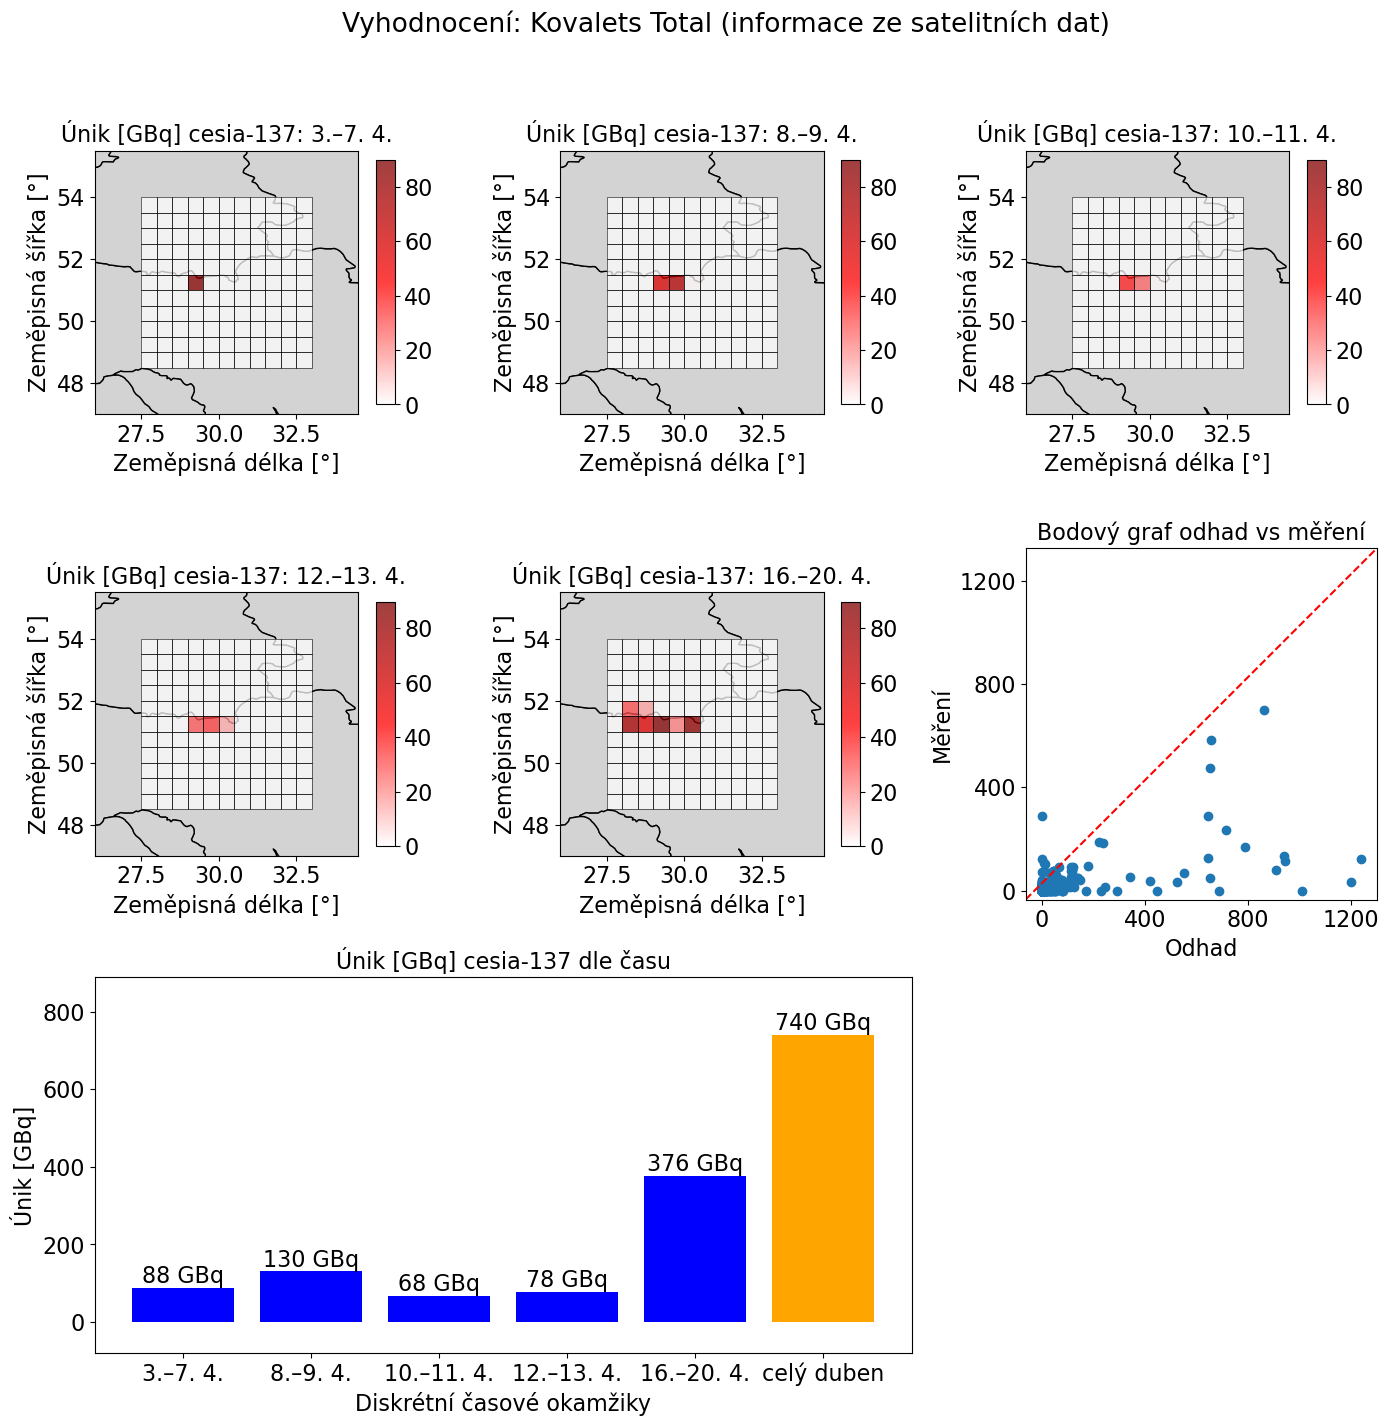

In [29]:
multiplot(kovaletTotal, "Kovalets Total (informace ze satelitních dat)", "KovaletsTotal", scaleKoefBq=False)
# plotBetaOnMap(kovaletTotal, model="Kovalet Total")

## Řídký model

In [30]:
betaHatSparsePositive,sigmaBetaSparsePositive,hist_omegaSparsePositive = positiveSparseBayesRegression(matrixX,y,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatSparsePositive,sigmaBetaSparsePositive, scaleKoefBq=True)

Pás nejistoty celkového úniku: [208.703, 349.354] GBq


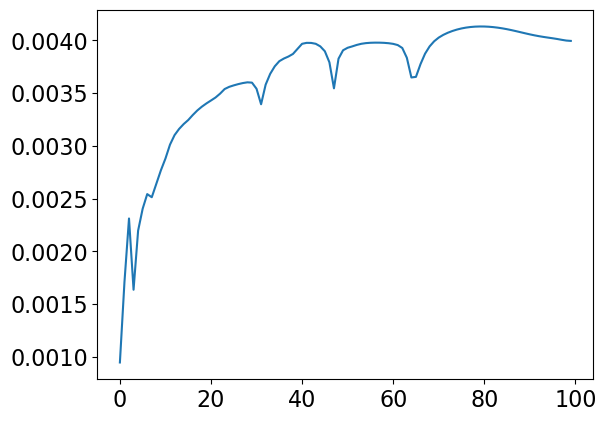

In [31]:
plt.plot(hist_omegaSparsePositive)
plt.show()

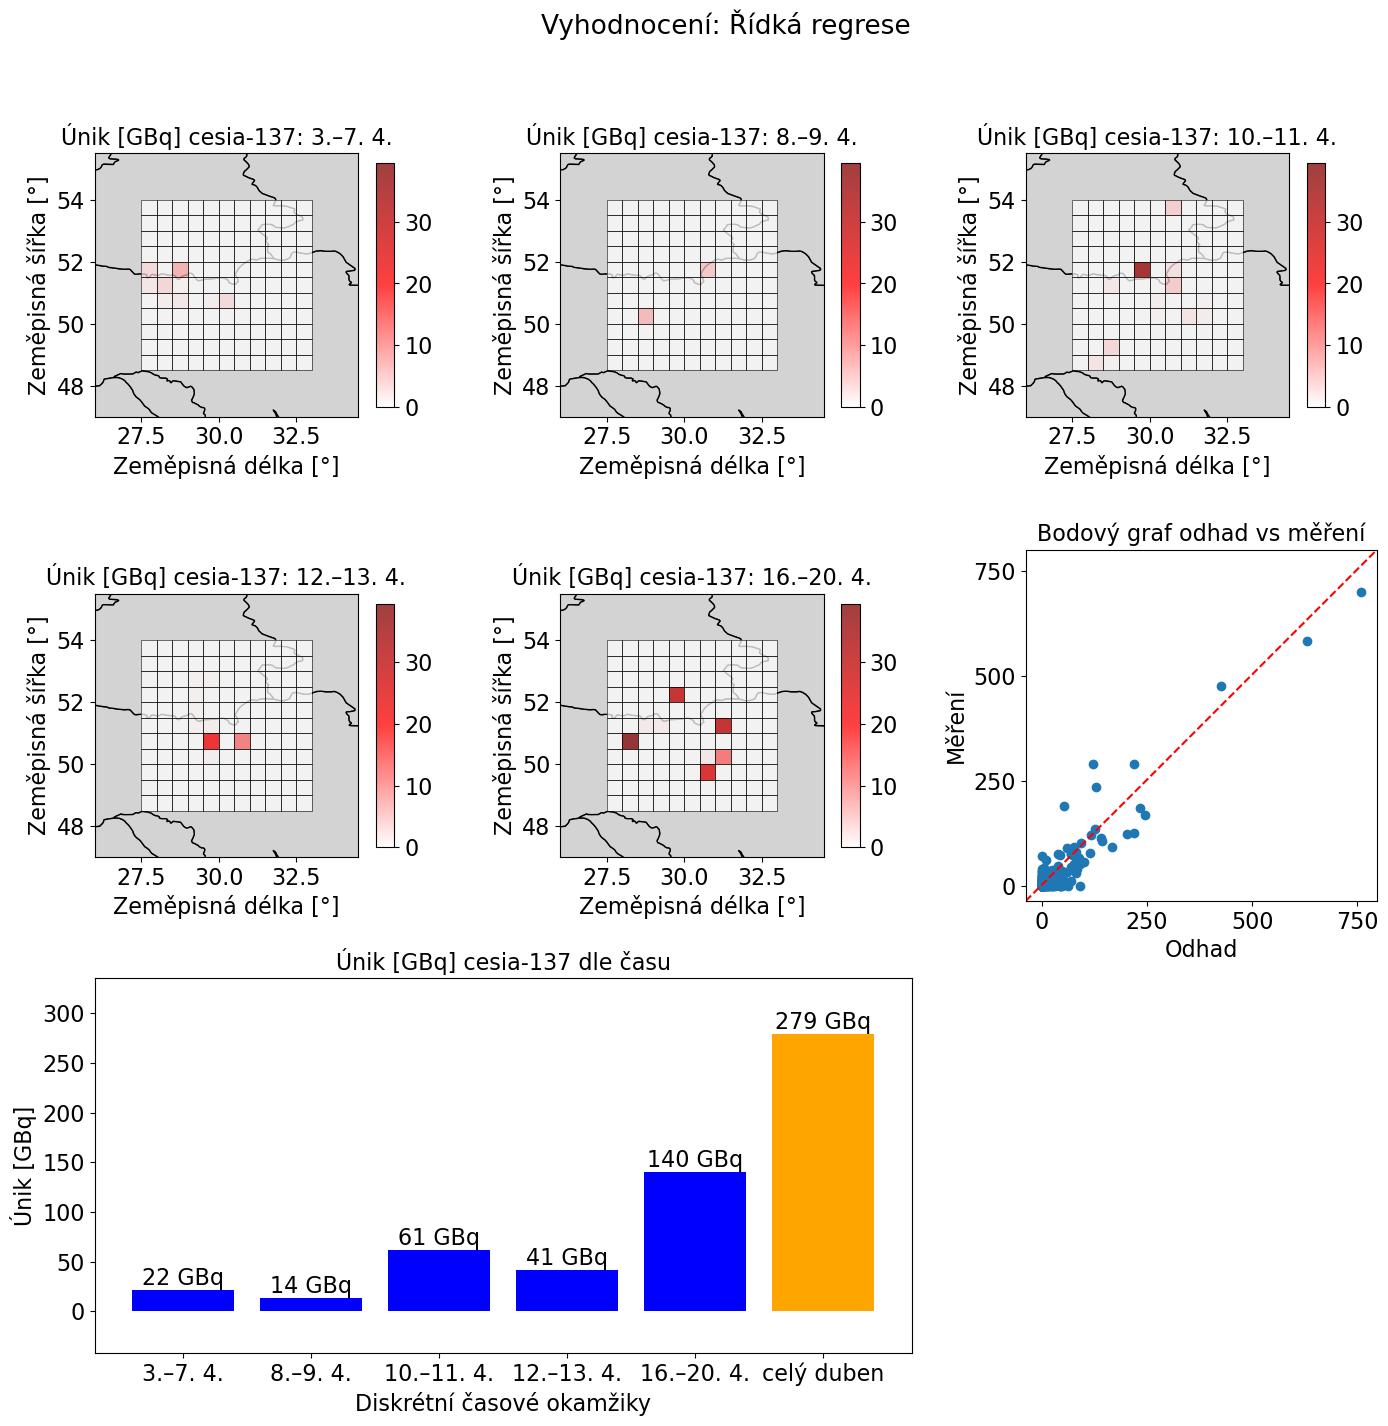

In [32]:
titleModel="Řídká regrese"
titleFile="SparseRegression"
multiplot(betaHatSparsePositive, titleModel, titleFile, scaleKoefBq=True) #, uncertainty=sigmaBetaSparsePositive)

## Hladká i řídký model

In [33]:
betaHatSmoothPositive,sigmaBetaSmoothPositive,hist_omegaSmoothPositive = bayesLVLPositiveRegression(matrixX,y,iterCount=iterCount, l0 = -1)
printTotalReleaseUncertaintyInterval(betaHatSmoothPositive,sigmaBetaSmoothPositive, scaleKoefBq=True)

Pás nejistoty celkového úniku: [278.992, 809.932] GBq


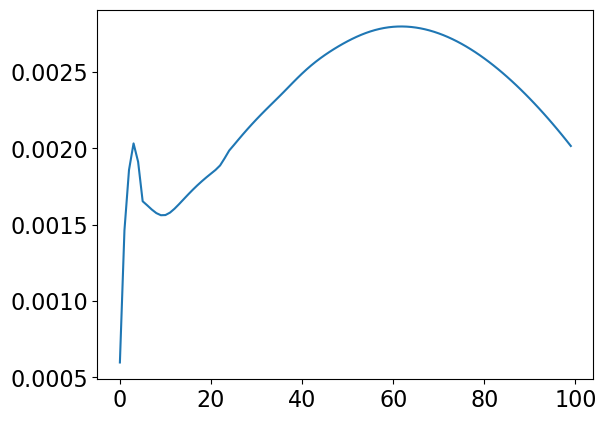

In [34]:
plt.plot(hist_omegaSmoothPositive)
plt.show()

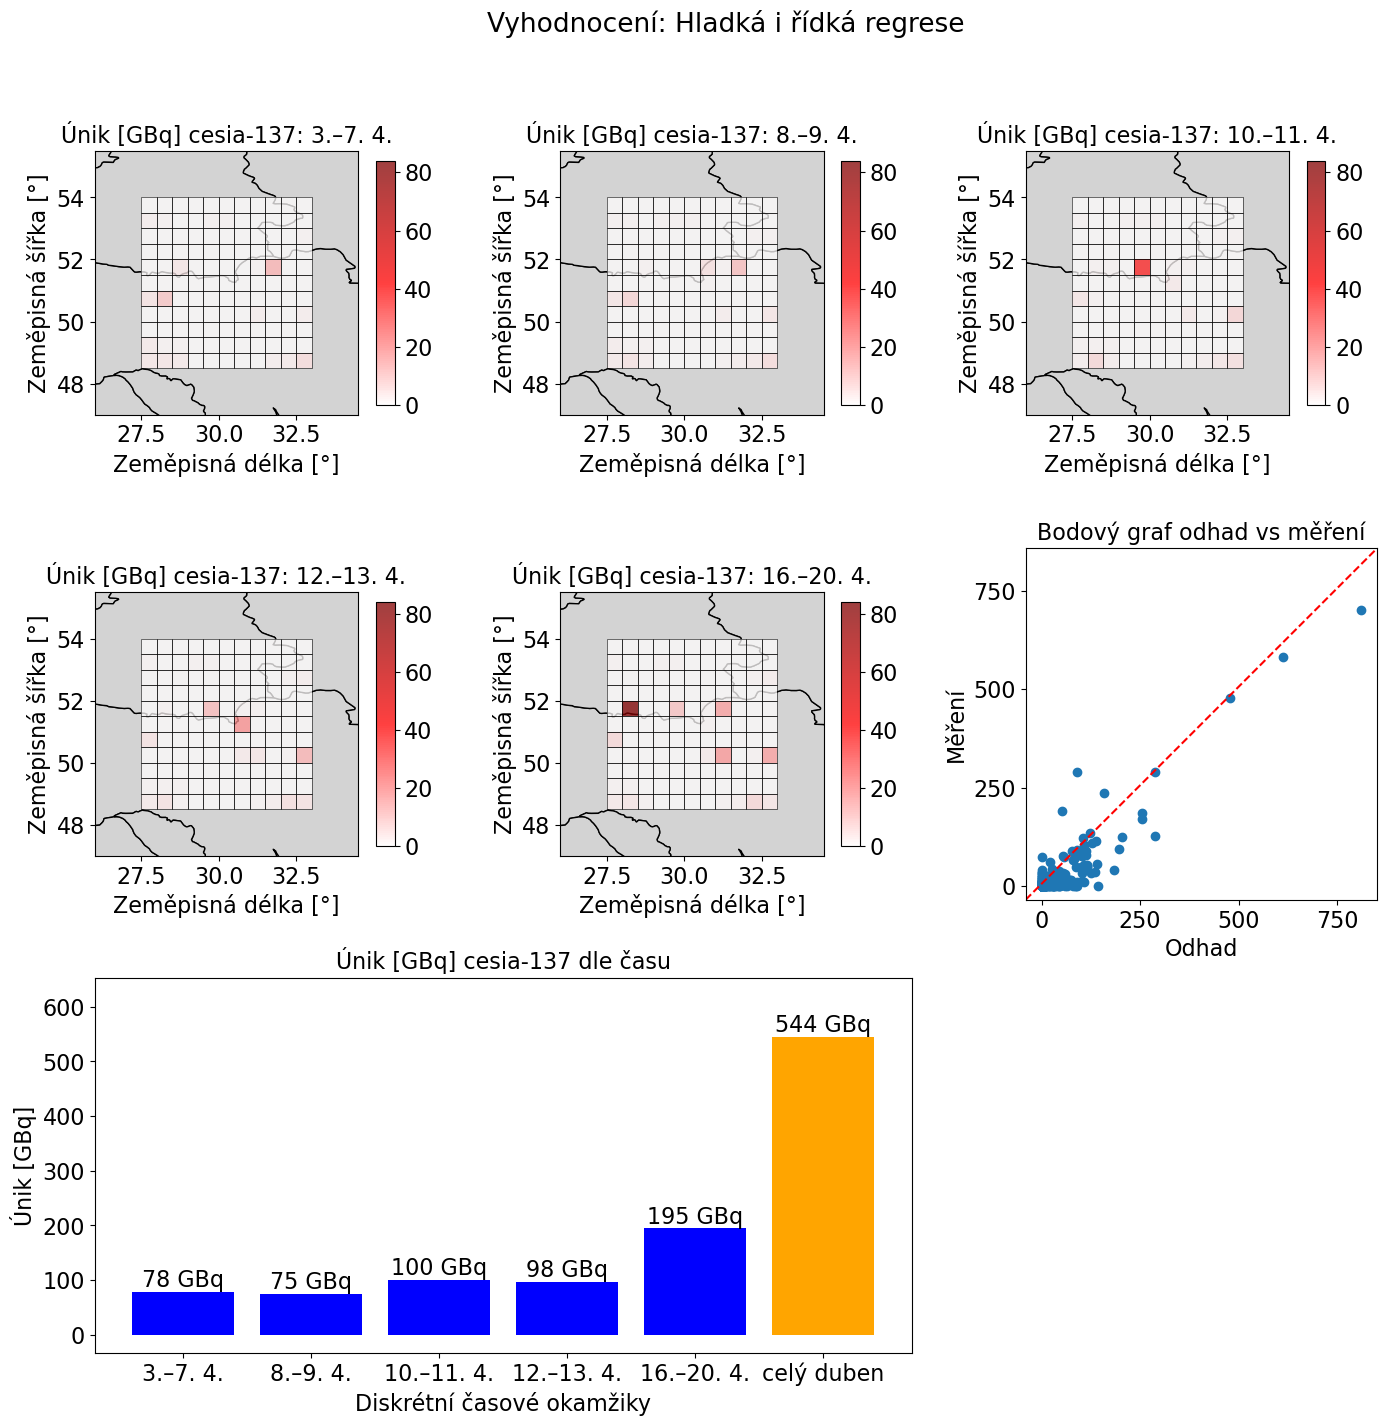

In [35]:
titleModel="Hladká i řídká regrese"
titleFile="SmoothRegression"
multiplot(betaHatSmoothPositive, titleModel, titleFile, scaleKoefBq=True)
# plotScatter(betaHatSmoothPositive,title=titleModel,scaled=False)
# plotRelease(betaHatSmoothPositive,title=titleModel,scaled=False)

## Časový model (základní)

In [36]:
betaHatTimePositive,sigmaBetaTimePositive,hist_omegaTimePositive = bayesLVLGeneralPositiveRegression(matrixX,y,iterCount=iterCount,activeL=timeModelL, l0 = -1)
printTotalReleaseUncertaintyInterval(betaHatTimePositive,sigmaBetaTimePositive, scaleKoefBq=True)

Pás nejistoty celkového úniku: [163.397, 269.339] GBq


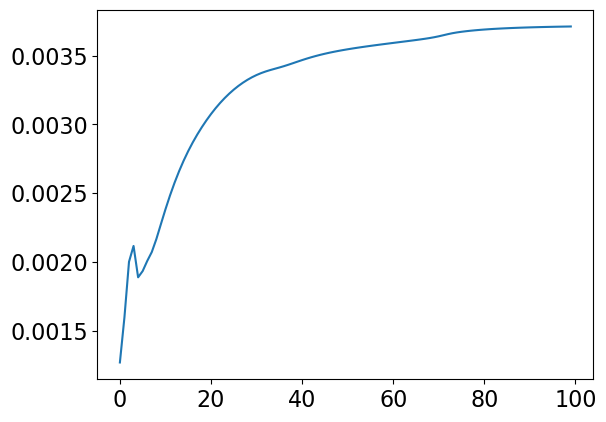

In [37]:
plt.plot(hist_omegaTimePositive)
plt.show()

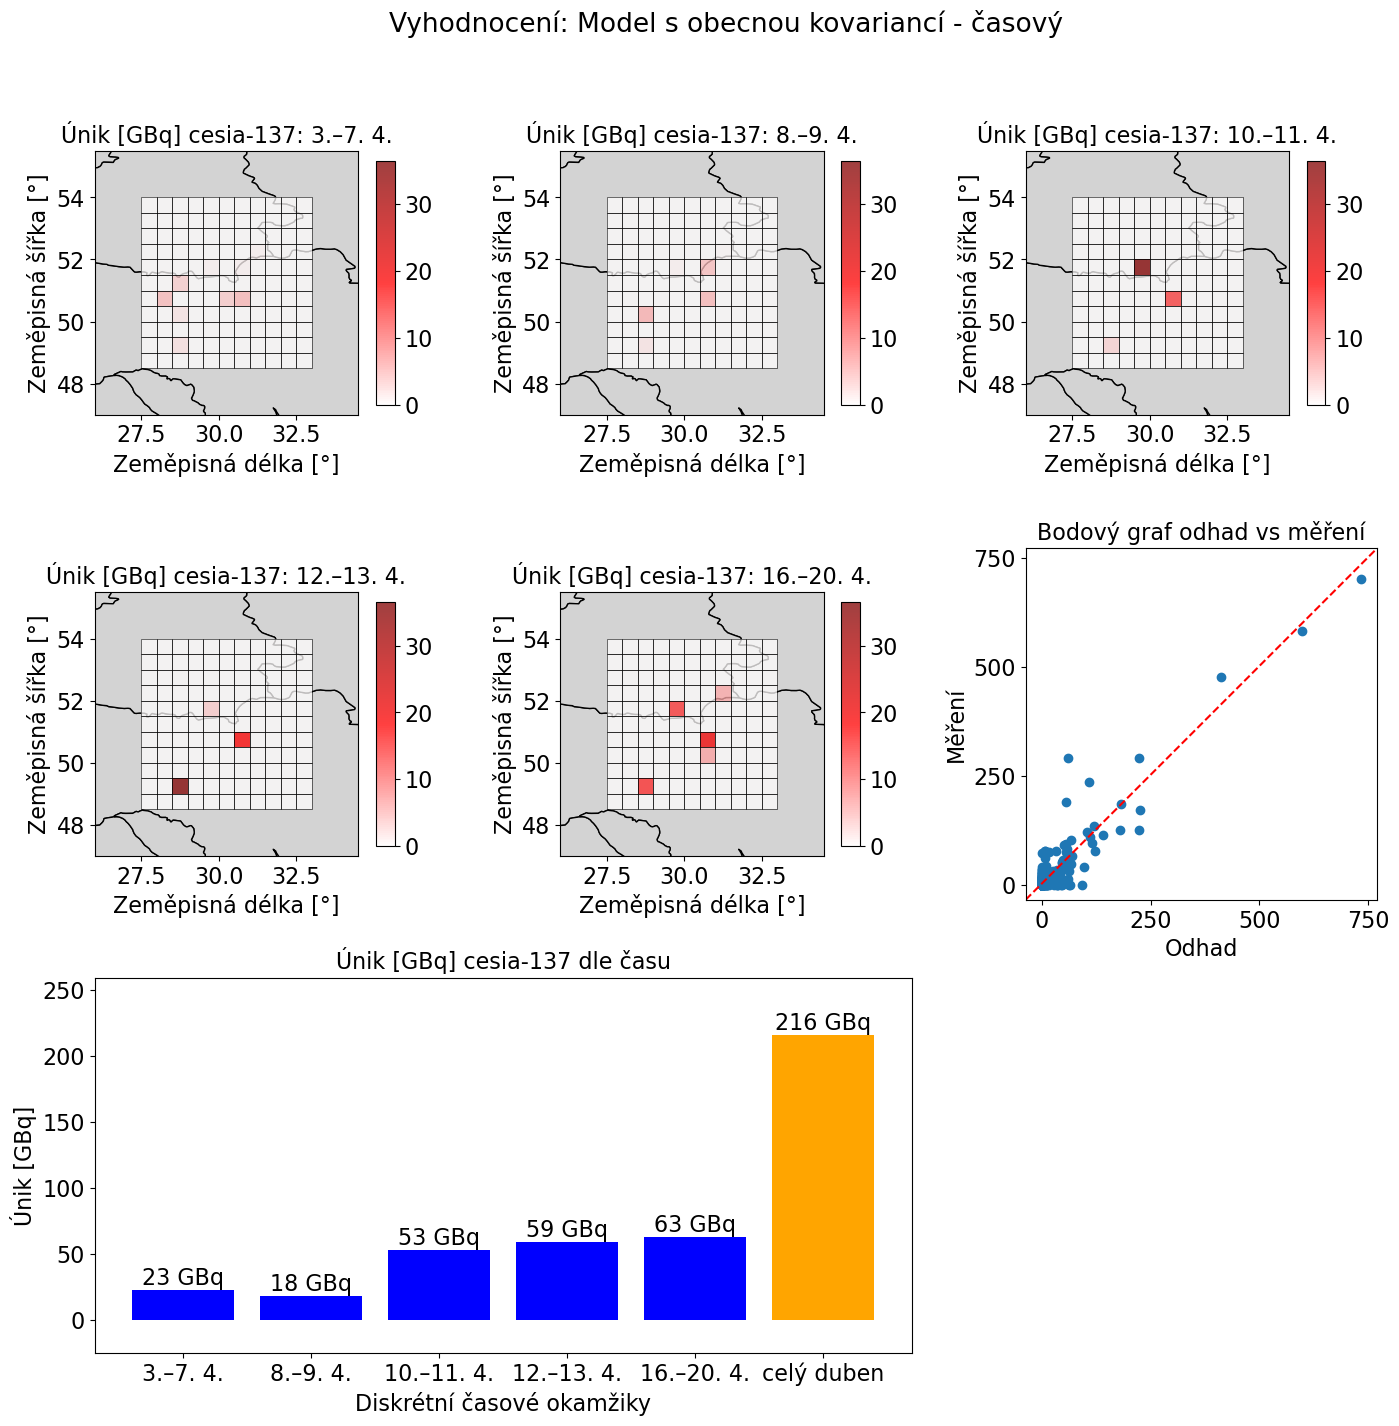

In [38]:
titleModel="Model s obecnou kovariancí - časový"
titleFile="TimeModel"
multiplot(betaHatTimePositive, titleModel, titleFile, scaleKoefBq=True)

## Prostorový model (základní)

In [39]:
betaHatSpacePositive,sigmaBetaSpacePositive,hist_omegaSpacePositive = bayesLVLGeneralPositiveRegression(matrixX,y,iterCount=iterCount,activeL=spaceModelL, l0 = -1)
printTotalReleaseUncertaintyInterval(betaHatSpacePositive,sigmaBetaSpacePositive, scaleKoefBq=True)

Pás nejistoty celkového úniku: [316.398, 668.391] GBq


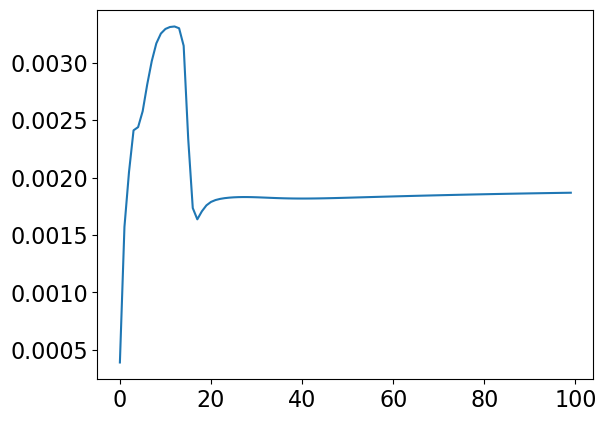

In [40]:
plt.plot(hist_omegaSpacePositive)
plt.show()

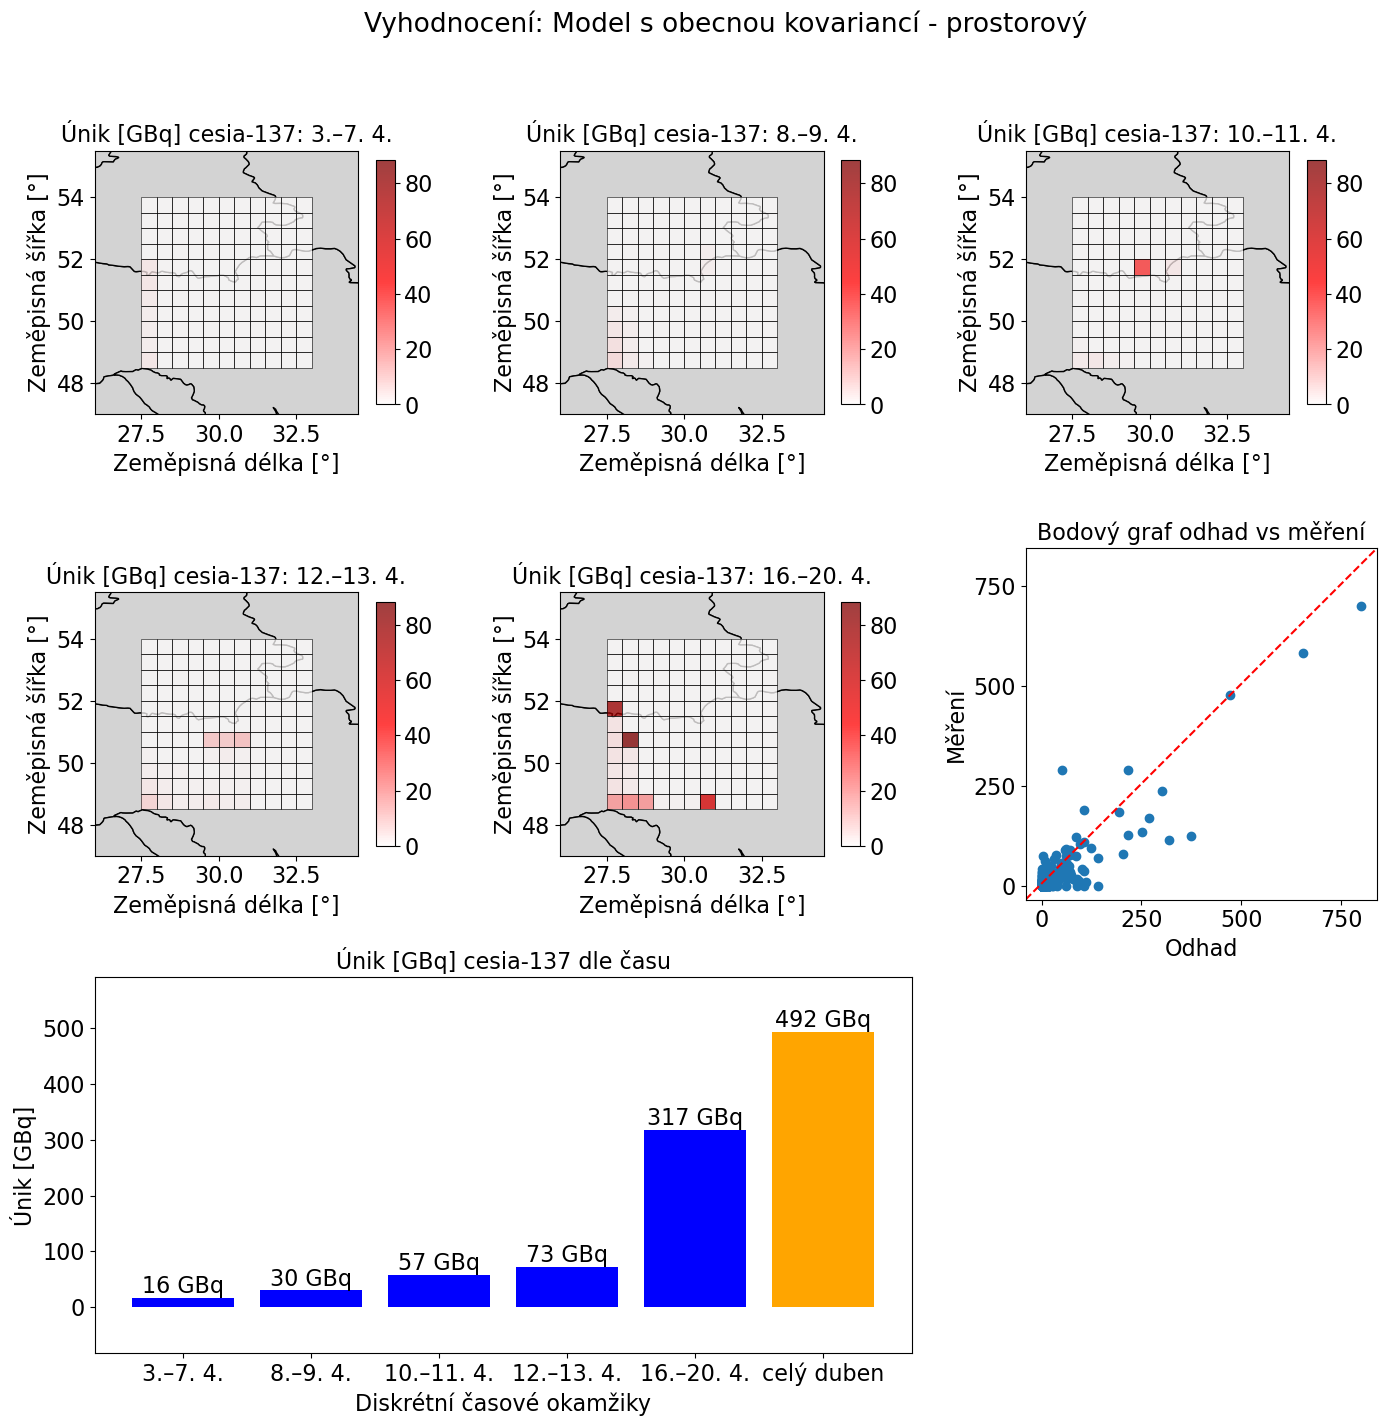

In [41]:
titleModel="Model s obecnou kovariancí - prostorový"
titleFile="SpaceModel"
multiplot(betaHatSpacePositive, titleModel, titleFile, scaleKoefBq=True)

## Časoprostorový model (základní)

In [42]:
betaHatSpaceAndTimePositive, sigmaBetaSpaceAndTimePositive, hist_omegaSpaceAndTimePositive = bayesLVLGeneralPositiveRegression(matrixX,y,iterCount=iterCount,activeL=spaceAndTimeModelL, l0 = -1)
printTotalReleaseUncertaintyInterval(betaHatSpaceAndTimePositive,sigmaBetaSpaceAndTimePositive, scaleKoefBq=True)

Pás nejistoty celkového úniku: [118.176, 288.160] GBq


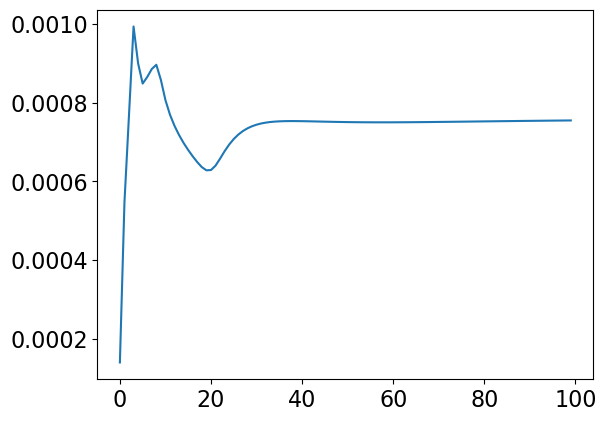

In [43]:
plt.plot(hist_omegaSpaceAndTimePositive)
plt.show()

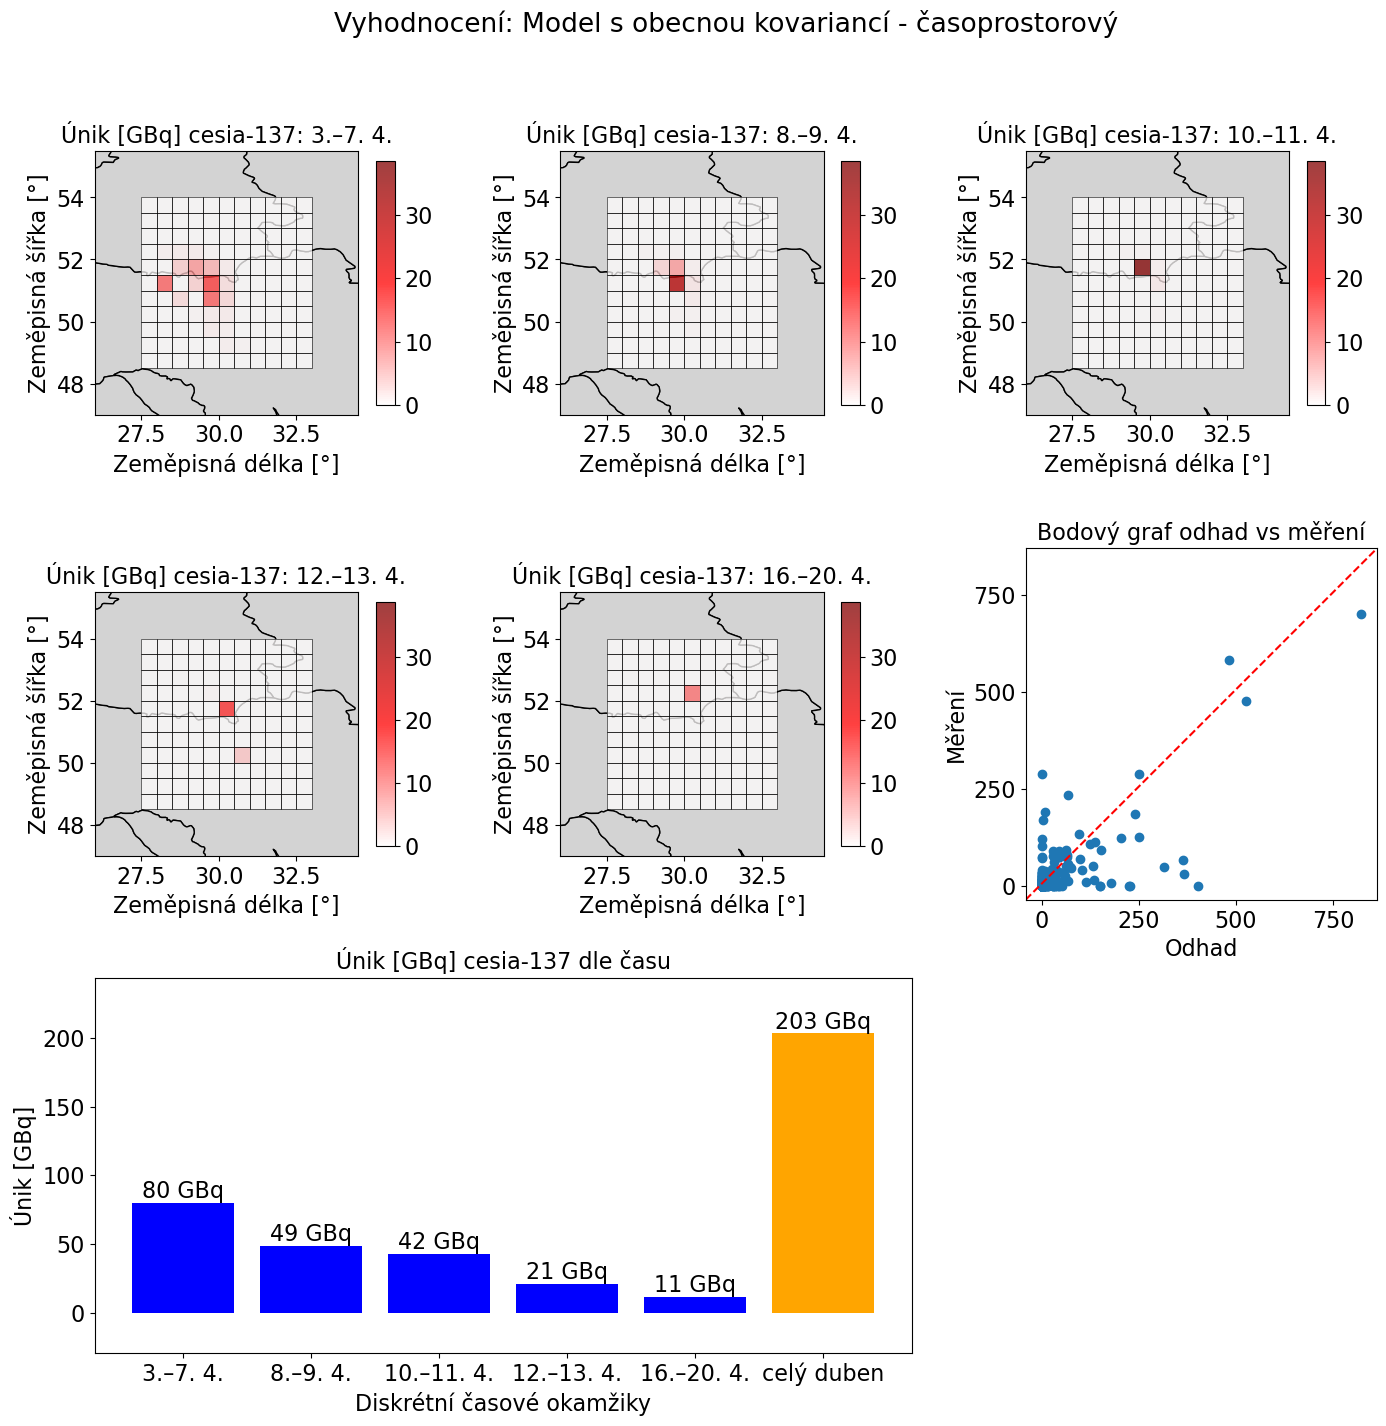

In [44]:
titleModel="Model s obecnou kovariancí - časoprostorový"
titleFile="SpaceAndTimeModel"
multiplot(betaHatSpaceAndTimePositive, titleModel, titleFile, scaleKoefBq=True)

# Experimenty s kovalets prior

Úprava apriorního rozdělení pro beta, kde střední hodnota $\theta$ je nahrazena $\beta_0$ získanou ze článku Kovalets

## Řídký model

In [45]:
betaHatBetaSparsePos, sigmaBetaBetaSparsePos, hist_omegaBetaSparsePos = positiveSparseBayesRegressionWithBeta(matrixX,y,kovaletTotal/koefBq,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatBetaSparsePos,sigmaBetaBetaSparsePos, scaleKoefBq=True)

Pás nejistoty celkového úniku: [287.975, 365.985] GBq


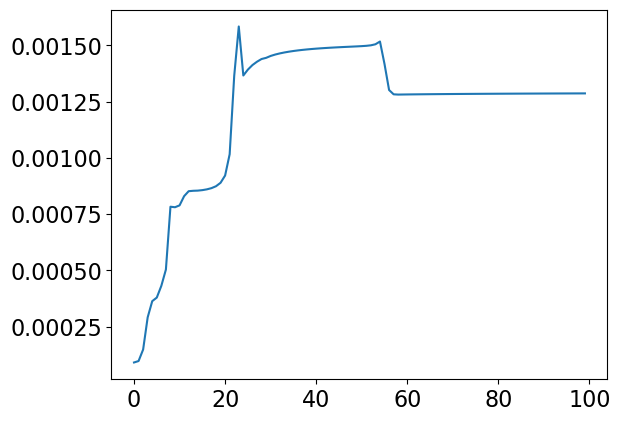

In [46]:
plt.plot(hist_omegaBetaSparsePos)
plt.show()

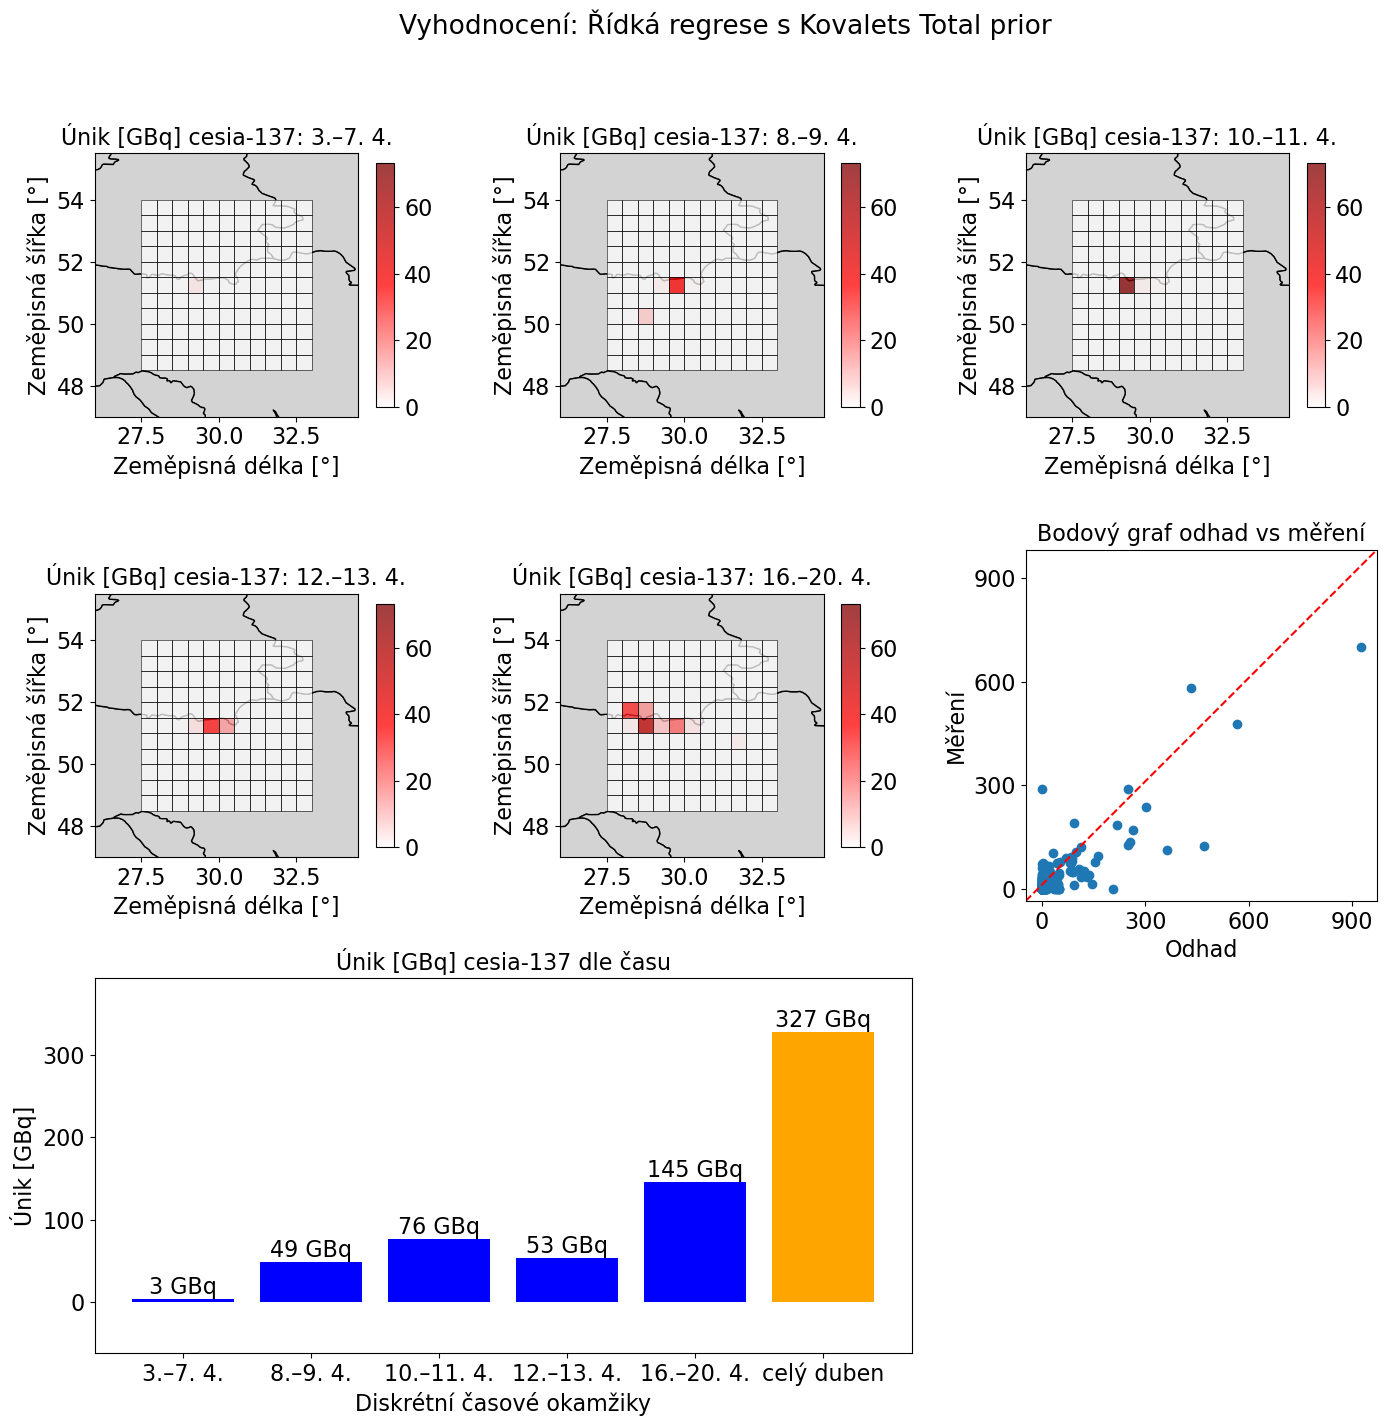

In [47]:
titleModel="Řídká regrese s Kovalets Total prior"
titleFile="SparseWithPrior"
multiplot(betaHatBetaSparsePos, titleModel, titleFile, scaleKoefBq=True)

## Hladký i řídký model

In [48]:
smoothL = [[i+1] for i in range(0,matrixX.shape[1]-1)] 
betaHatSmoothBetaPos, sigmaBetaSmoothBetaPos, hist_omegaSmoothBetaPos = bayesGeneralLVLRegressionWithBetaPositive(matrixX,y,l0=-1,activeL=smoothL,betaIn=kovaletTotal/koefBq,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatSmoothBetaPos,sigmaBetaSmoothBetaPos, scaleKoefBq=True)

Pás nejistoty celkového úniku: [361.036, 1608.176] GBq


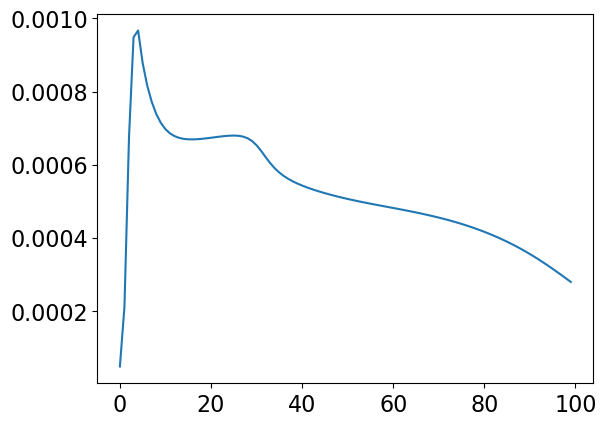

In [49]:
plt.plot(hist_omegaSmoothBetaPos)
plt.show()

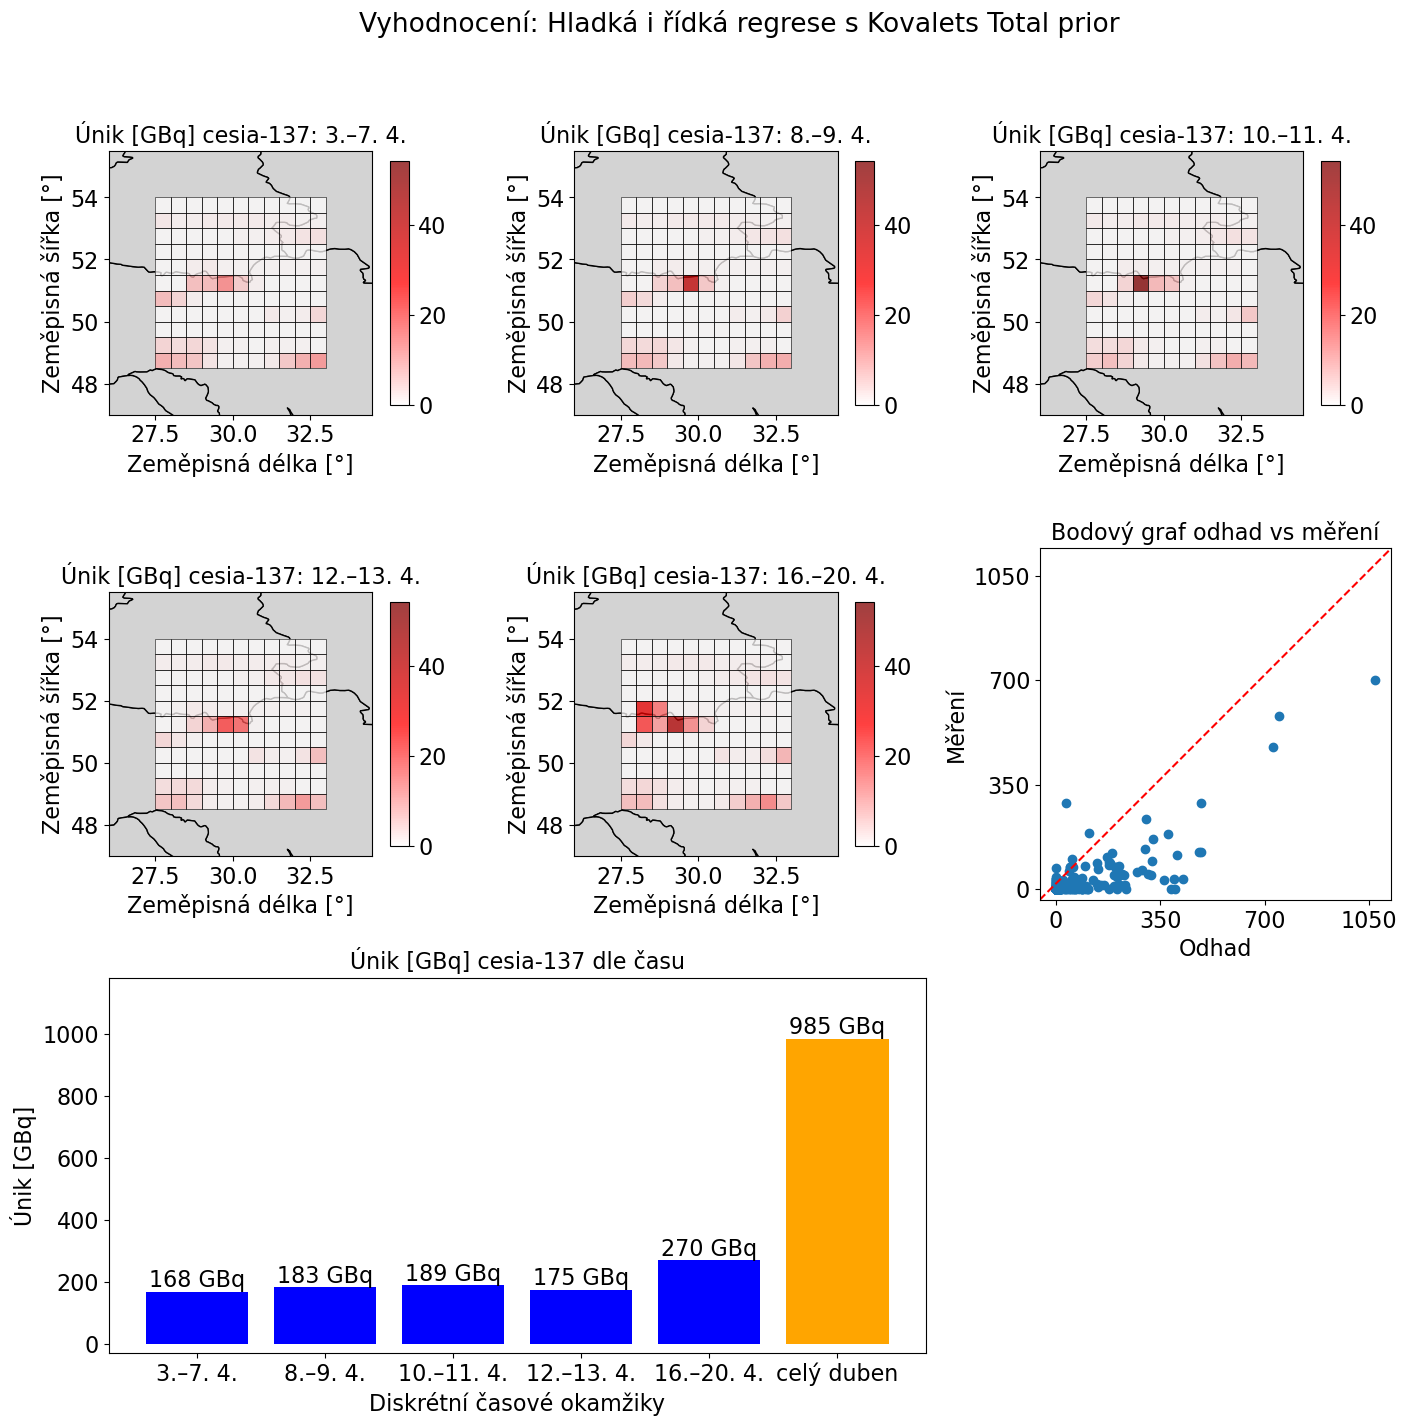

In [50]:
titleModel="Hladká i řídká regrese s Kovalets Total prior"
titleFile="SmoothWithPrior"
multiplot(betaHatSmoothBetaPos, titleModel, titleFile, scaleKoefBq=True)
# plotScatter(betaHatSmoothBetaPos,title=titleModel,scaled=False)
# plotRelease(betaHatSmoothBetaPos,title=titleModel,scaled=False)

Jelikož metoda nezkonvergovala dle $\omega$, kód byl spuštěn znovu s více iteracemi. Výsledek -- lze vidět na první pohled -- nedopadl dobře.

In [51]:
# longer iter
betaHatSmoothBetaPosLI, sigmaBetaSmoothBetaPosLI, hist_omegaSmoothBetaPosLI = bayesGeneralLVLRegressionWithBetaPositive(matrixX,y,l0=-1,activeL=smoothL,betaIn=kovaletTotal/koefBq,iterCount=251)
printTotalReleaseUncertaintyInterval(betaHatSmoothBetaPosLI,sigmaBetaSmoothBetaPosLI, scaleKoefBq=True)

Pás nejistoty celkového úniku: [10833.684, 77343.859] GBq


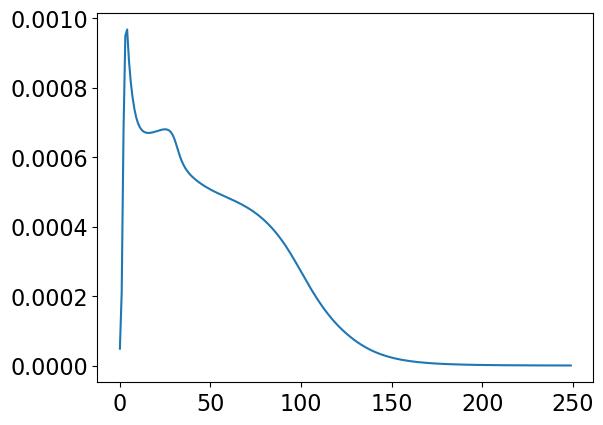

In [52]:
plt.plot(hist_omegaSmoothBetaPosLI)
plt.show()

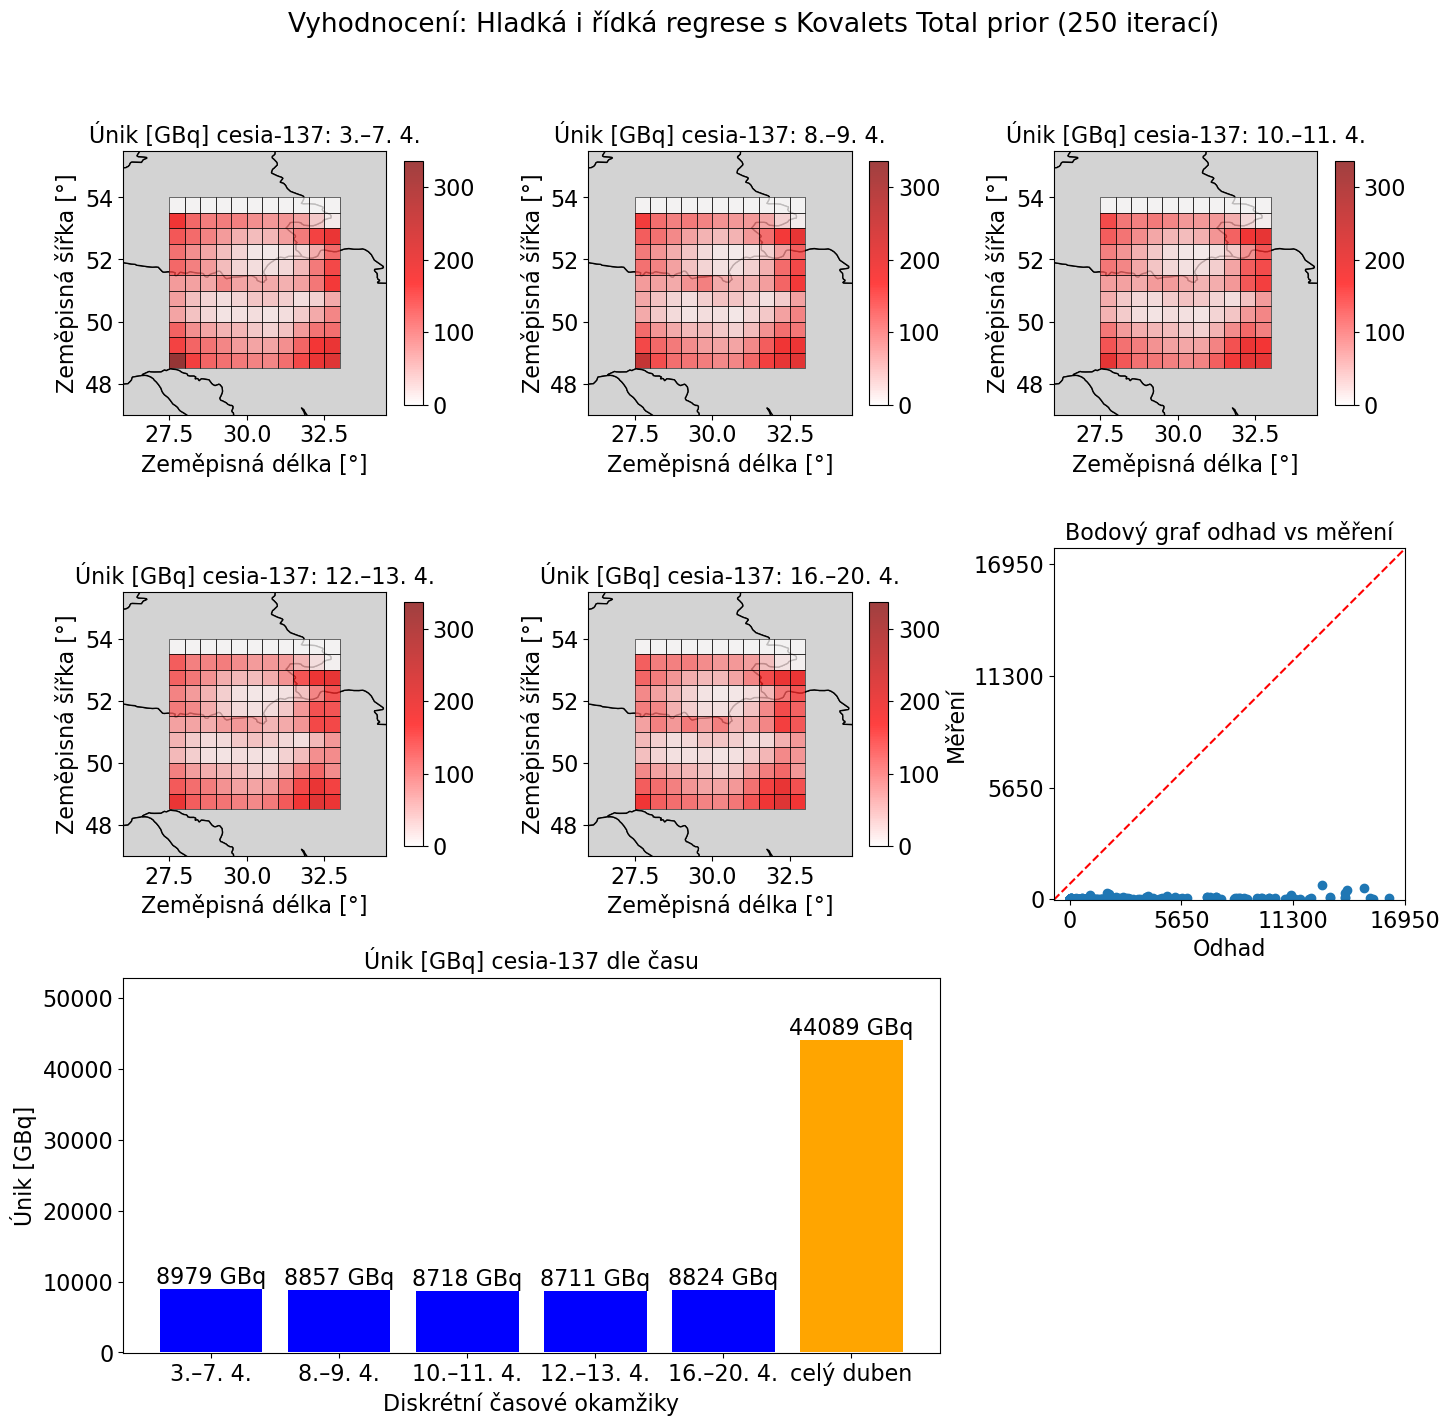

In [53]:
titleModel="Hladká i řídká regrese s Kovalets Total prior (250 iterací)"
titleFile="SmoothWithPriorLongIter"
multiplot(betaHatSmoothBetaPosLI, titleModel, titleFile, scaleKoefBq=True)
# plotScatter(betaHatSmoothBetaPos,title=titleModel,scaled=False)
# plotRelease(betaHatSmoothBetaPos,title=titleModel,scaled=False)

## Časový model

In [54]:
betaHatTimeBetaPos, sigmaBetaTimeBetaPos, hist_omegaTimeBetaPos = bayesGeneralLVLRegressionWithBetaPositive(matrixX,y,l0=-1,activeL=timeModelL,betaIn=kovaletTotal/koefBq,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatTimeBetaPos,sigmaBetaTimeBetaPos, scaleKoefBq=True)

Pás nejistoty celkového úniku: [351.701, 584.185] GBq


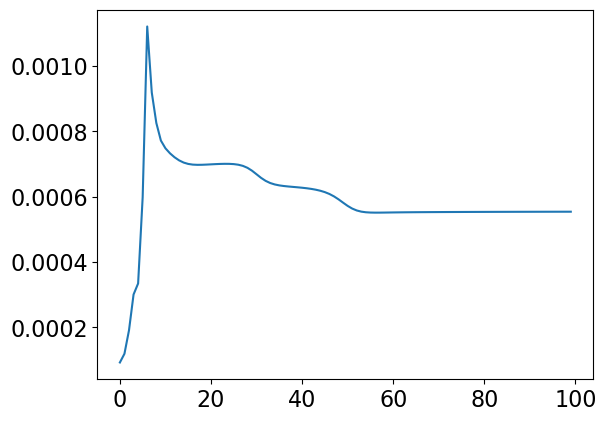

In [55]:
plt.plot(hist_omegaTimeBetaPos)
plt.show()

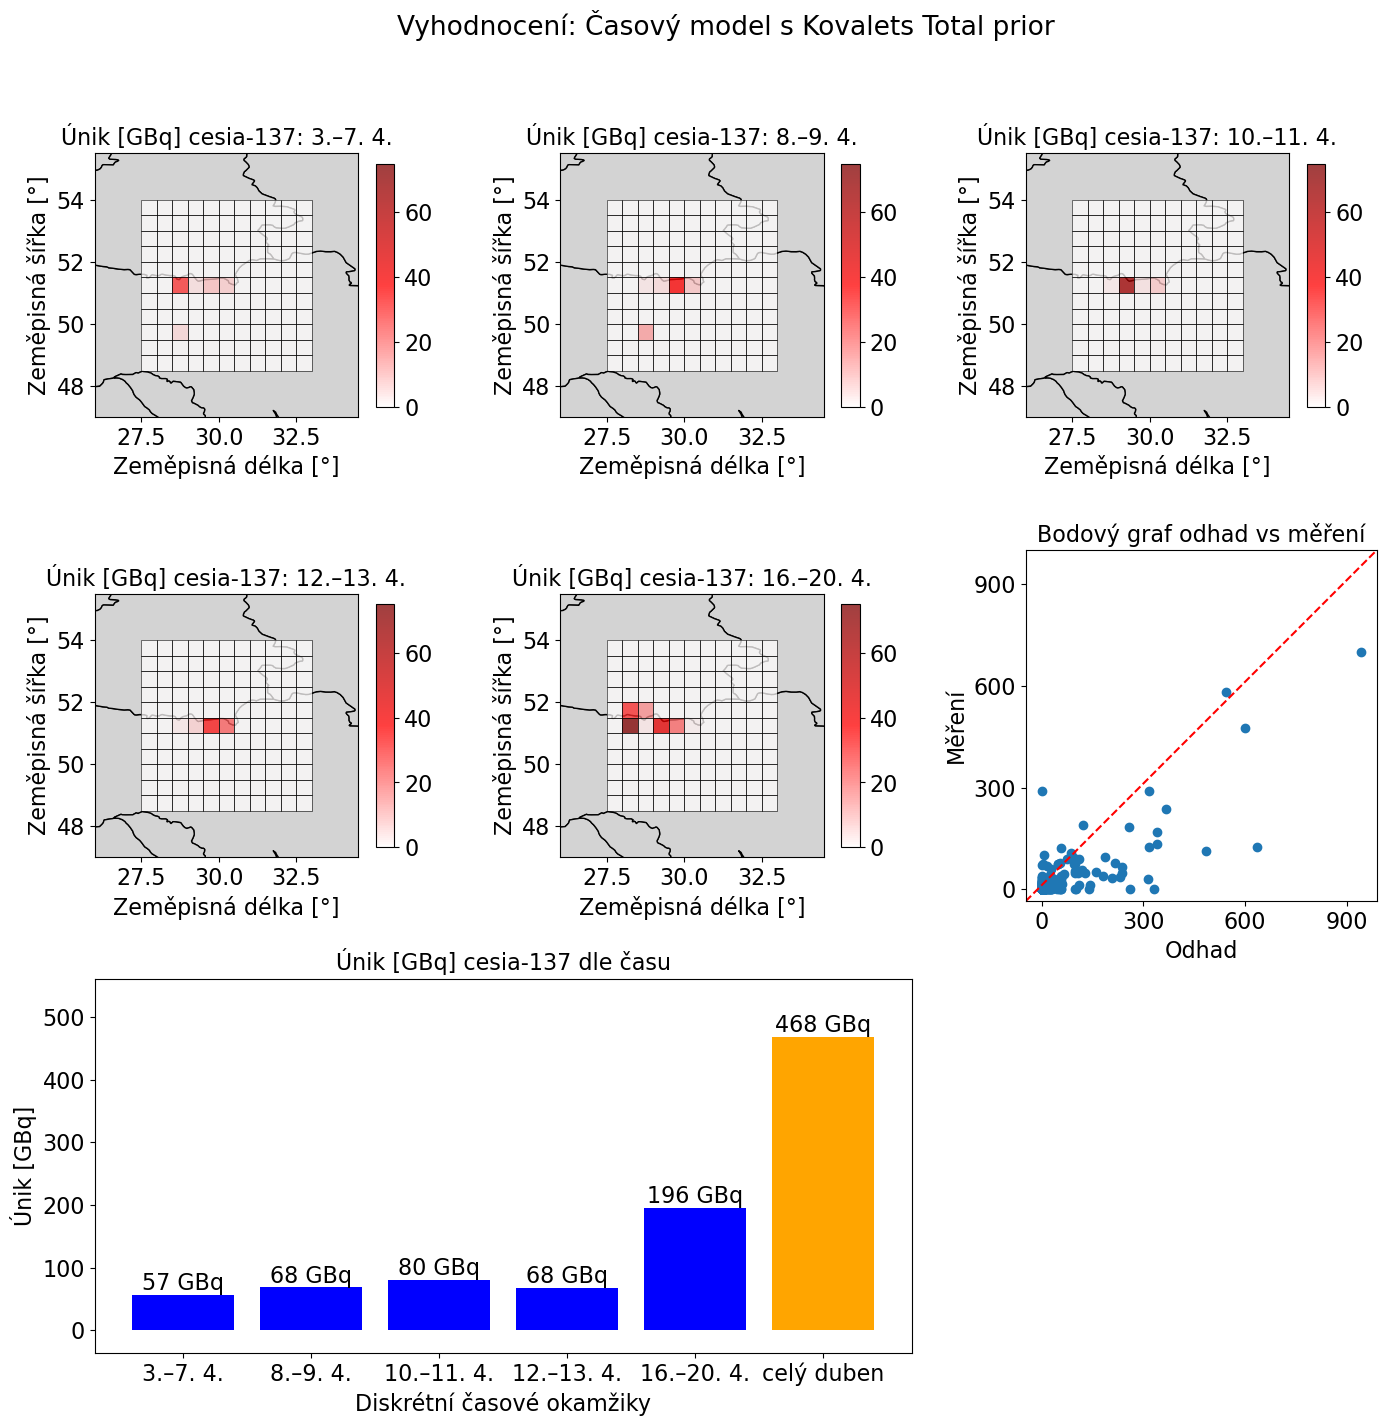

In [56]:
titleModel="Časový model s Kovalets Total prior"
titleFile="TimeModelWithPrior"
multiplot(betaHatTimeBetaPos, titleModel, titleFile, scaleKoefBq=True)

## Prostorový model

In [57]:
betaHatSpaceBetaPos, sigmaBetaSpaceBetaPos, hist_omegaSpaceBetaPos = bayesGeneralLVLRegressionWithBetaPositive(matrixX,y,l0=-1,activeL=spaceModelL,betaIn=kovaletTotal/koefBq,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatSpaceBetaPos,sigmaBetaSpaceBetaPos, scaleKoefBq=True)

Pás nejistoty celkového úniku: [479.564, 1162.911] GBq


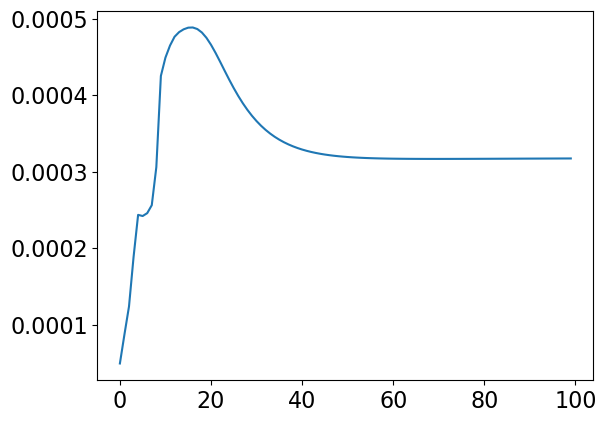

In [58]:
plt.plot(hist_omegaSpaceBetaPos)
plt.show()

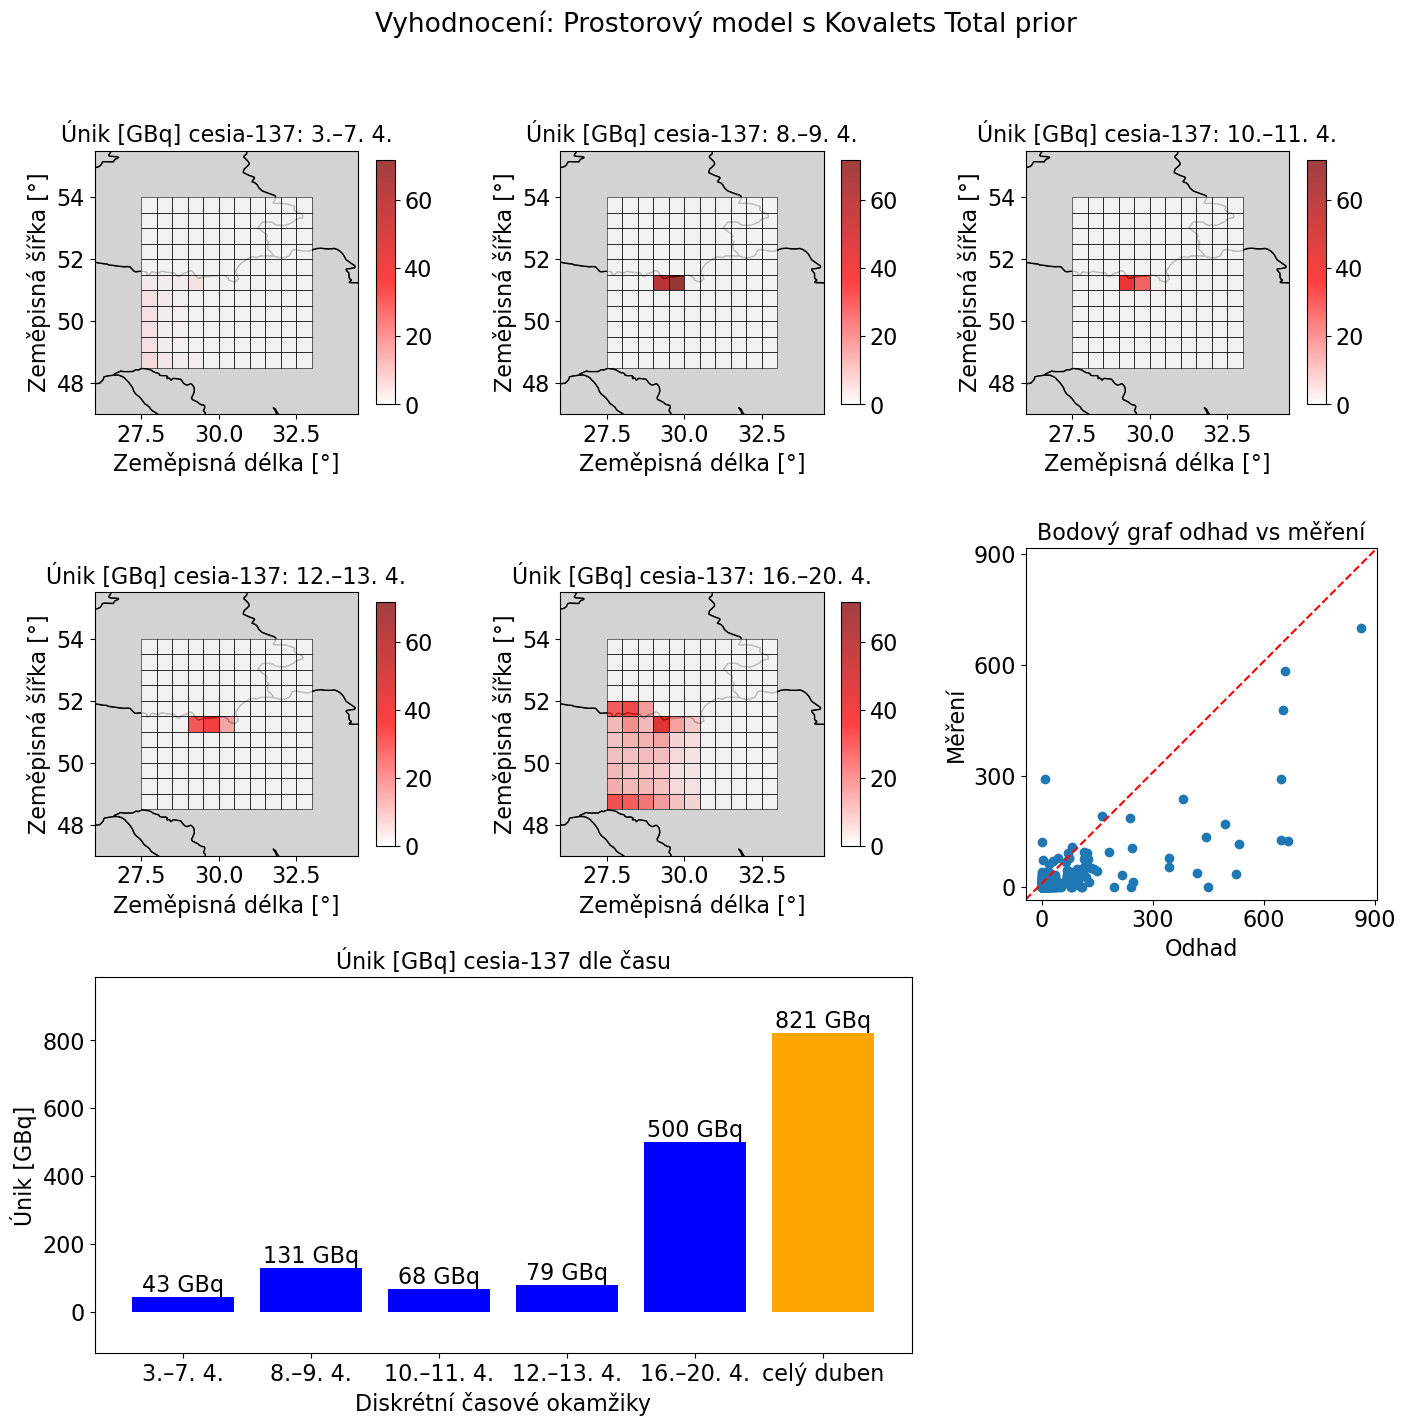

In [59]:
titleModel="Prostorový model s Kovalets Total prior"
titleFile="SpaceModelWithPrior"
multiplot(betaHatSpaceBetaPos, titleModel, titleFile, scaleKoefBq=True)

## Časoprostorový model

In [60]:
betaHatSpaceAndTimeBetaPos, sigmaBetaSpaceAndTimeBetaPos, hist_omegaSpaceAndTimeBetaPos = bayesGeneralLVLRegressionWithBetaPositive(matrixX,y,l0=-1,activeL=spaceAndTimeModelL,betaIn=kovaletTotal/koefBq,iterCount=iterCount)
printTotalReleaseUncertaintyInterval(betaHatSpaceAndTimeBetaPos, sigmaBetaSpaceAndTimeBetaPos, scaleKoefBq=True)

Pás nejistoty celkového úniku: [558.650, 794.209] GBq


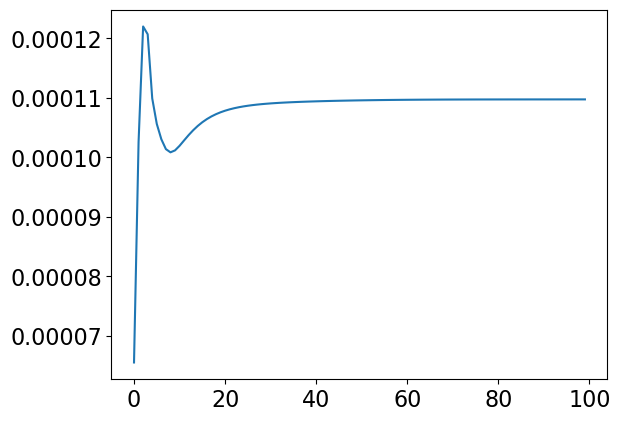

In [61]:
plt.plot(hist_omegaSpaceAndTimeBetaPos)
plt.show()

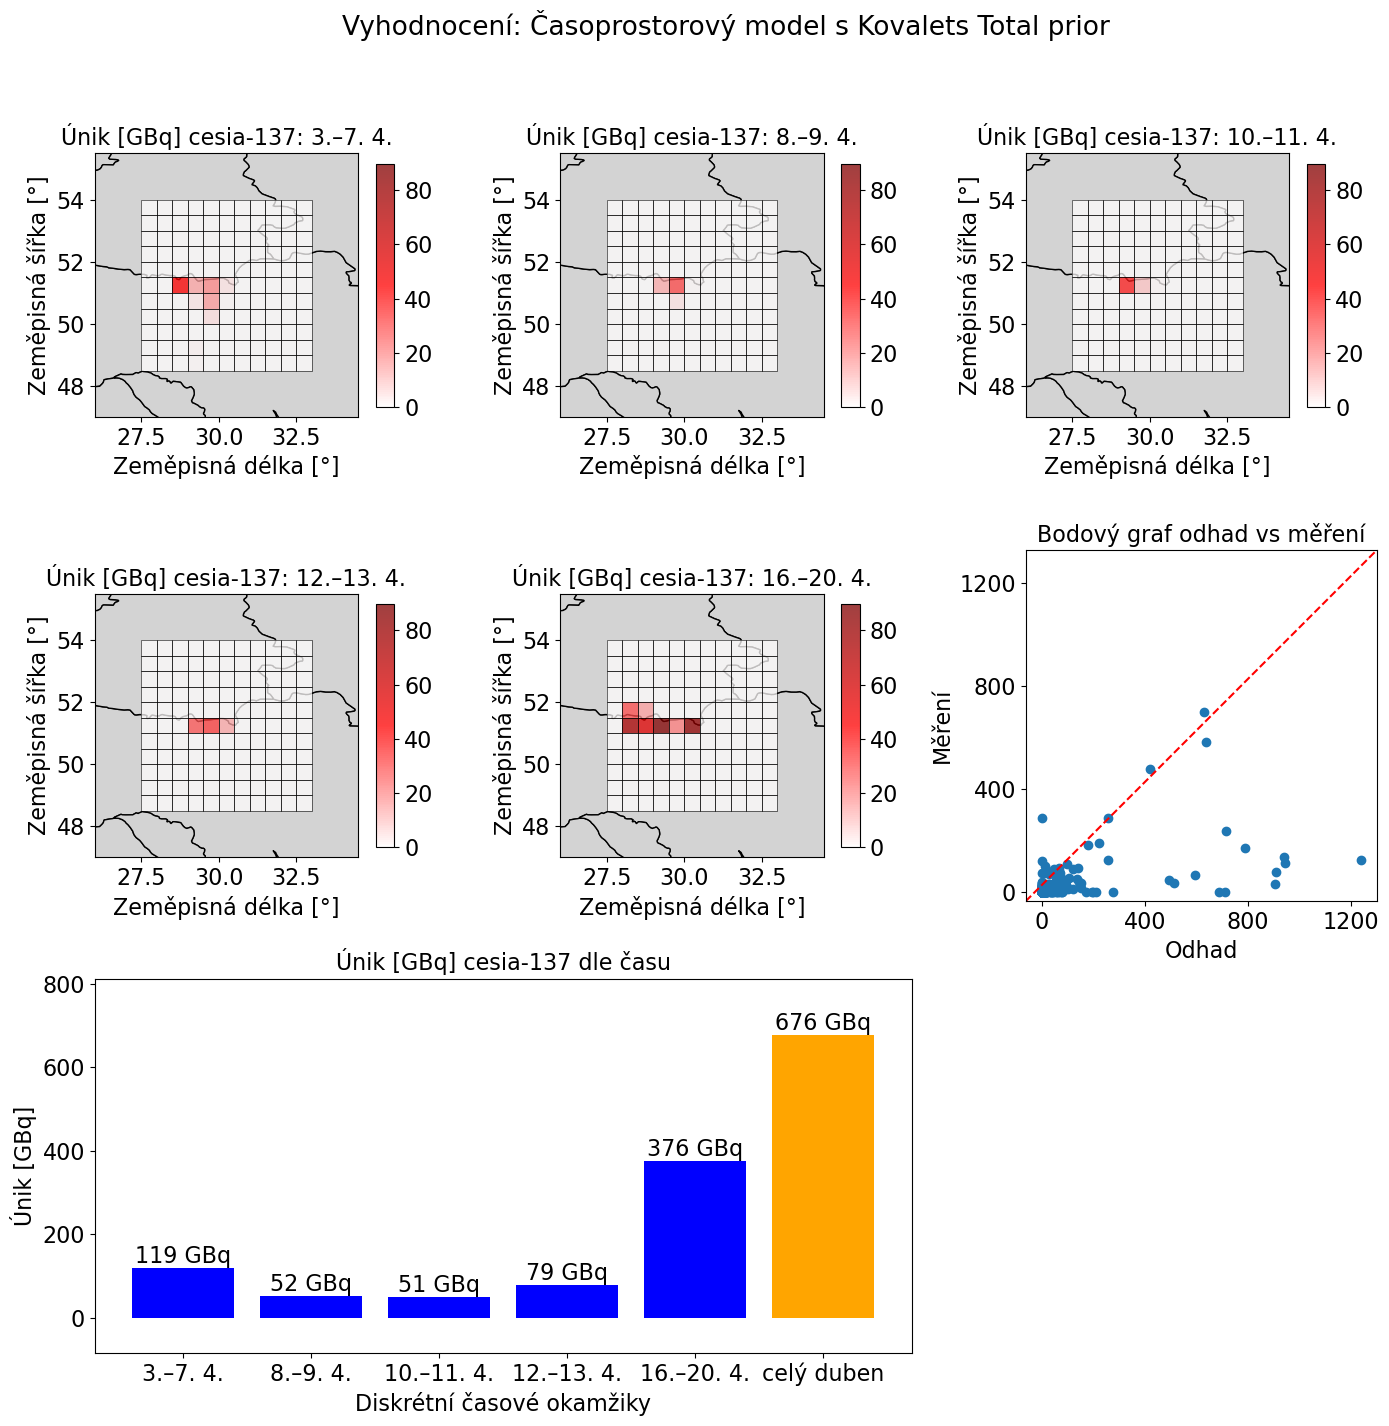

In [62]:
titleModel="Časoprostorový model s Kovalets Total prior"
titleFile="SpaceAndTimeModelWithPrior"
multiplot(betaHatSpaceAndTimeBetaPos, titleModel, titleFile, scaleKoefBq=True)

# Klasické přístupy

## Lineární regrese

In [63]:
from sklearn.linear_model import LinearRegression

linearRegressionModel = LinearRegression(fit_intercept=False).fit(matrixX, y)
betaHatLR = linearRegressionModel.coef_.reshape(-1,1)

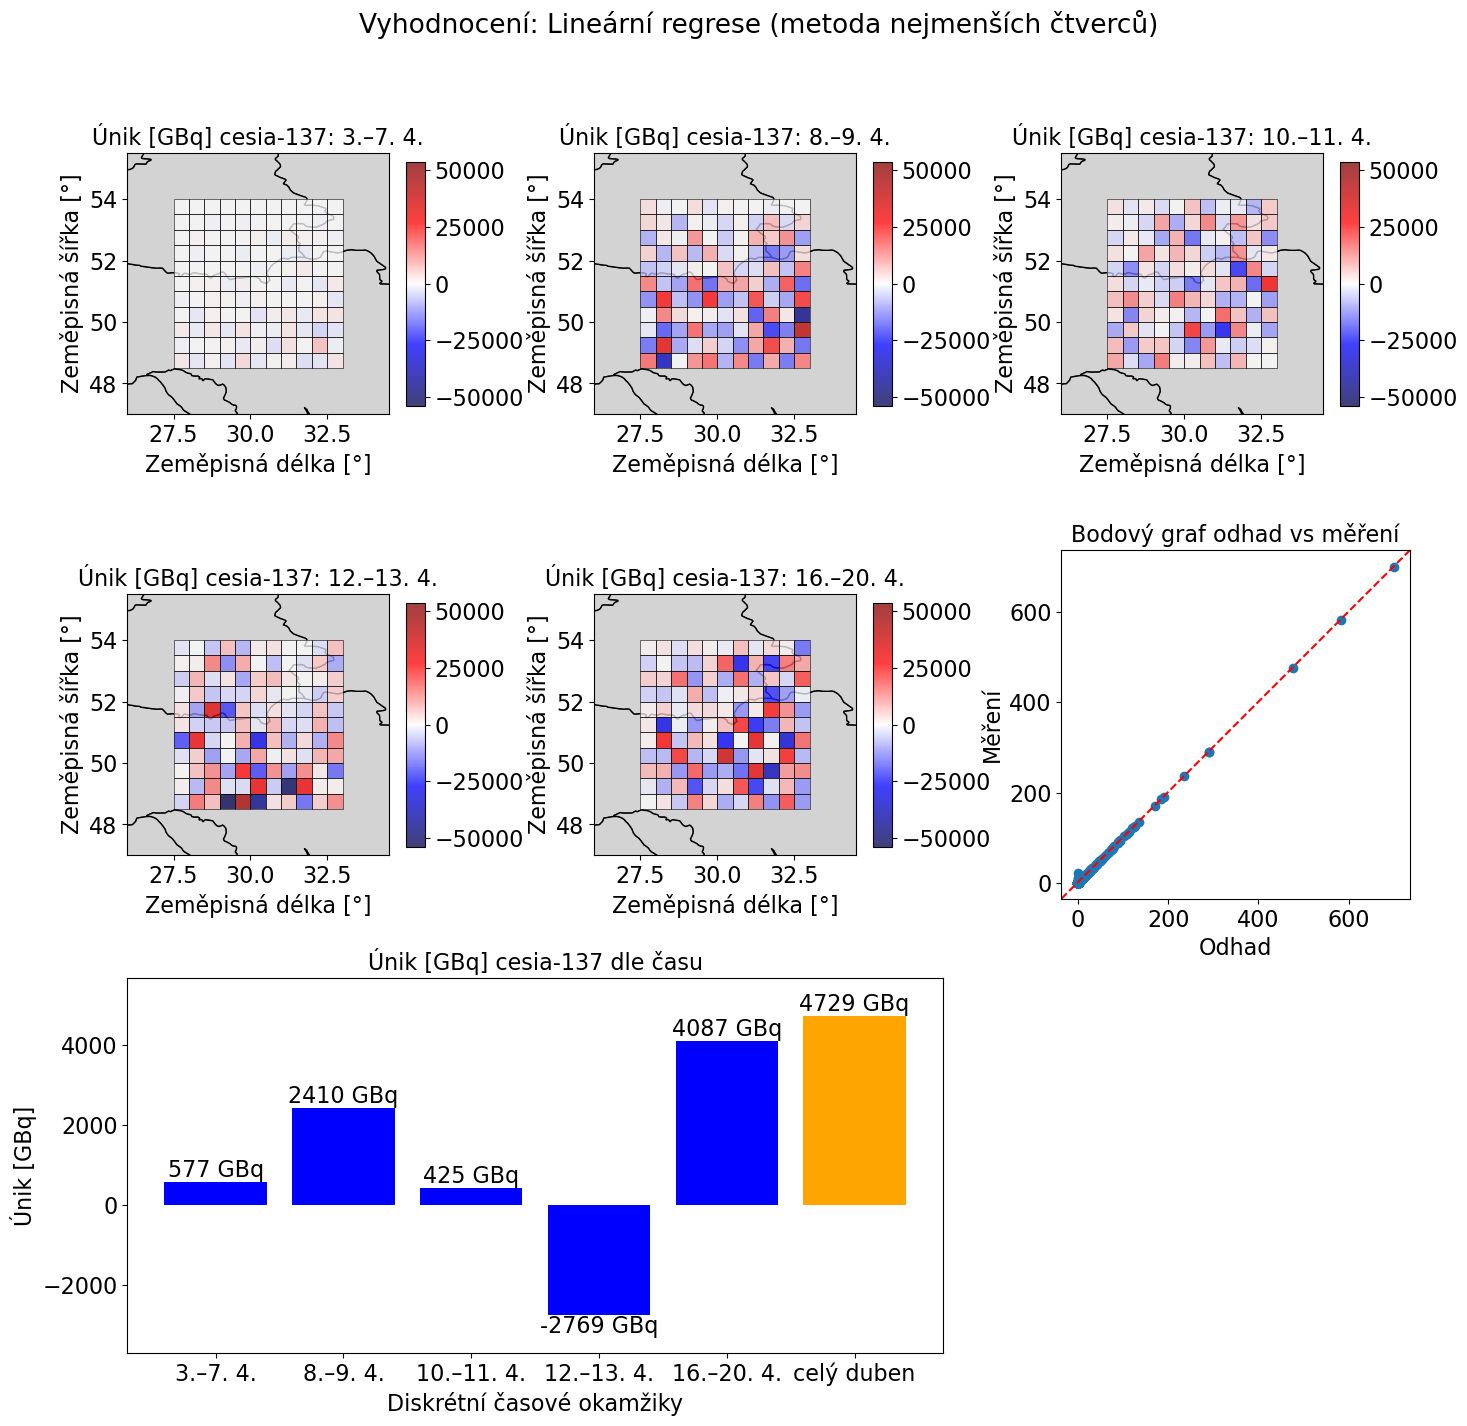

In [64]:
titleModel="Lineární regrese (metoda nejmenších čtverců)"
titleFile="LinearRegression"
multiplot(betaHatLR, titleModel, titleFile, scaleKoefBq=True, w_padIn=2.2)

## Hřebenová regrese

Pro odhad tunícího parametru lambda bylo využita křížová validace (konkrétně varianta leave-one-out, kde parametr křížové validace je roven 1) 

In [65]:
from sklearn.linear_model import RidgeCV

alphasRange = [*np.arange(0.0001,1,0.001)]+[*np.arange(1.01,5,0.01)]+[*np.arange(6,16,0.1)]+[*np.arange(17,100,5)]
ridgeRegressionModelCrossValidation = RidgeCV(alphas = alphasRange, fit_intercept=False).fit(matrixX, y.reshape(-1))

betaHatRidge = ridgeRegressionModelCrossValidation.coef_.reshape(-1,1)

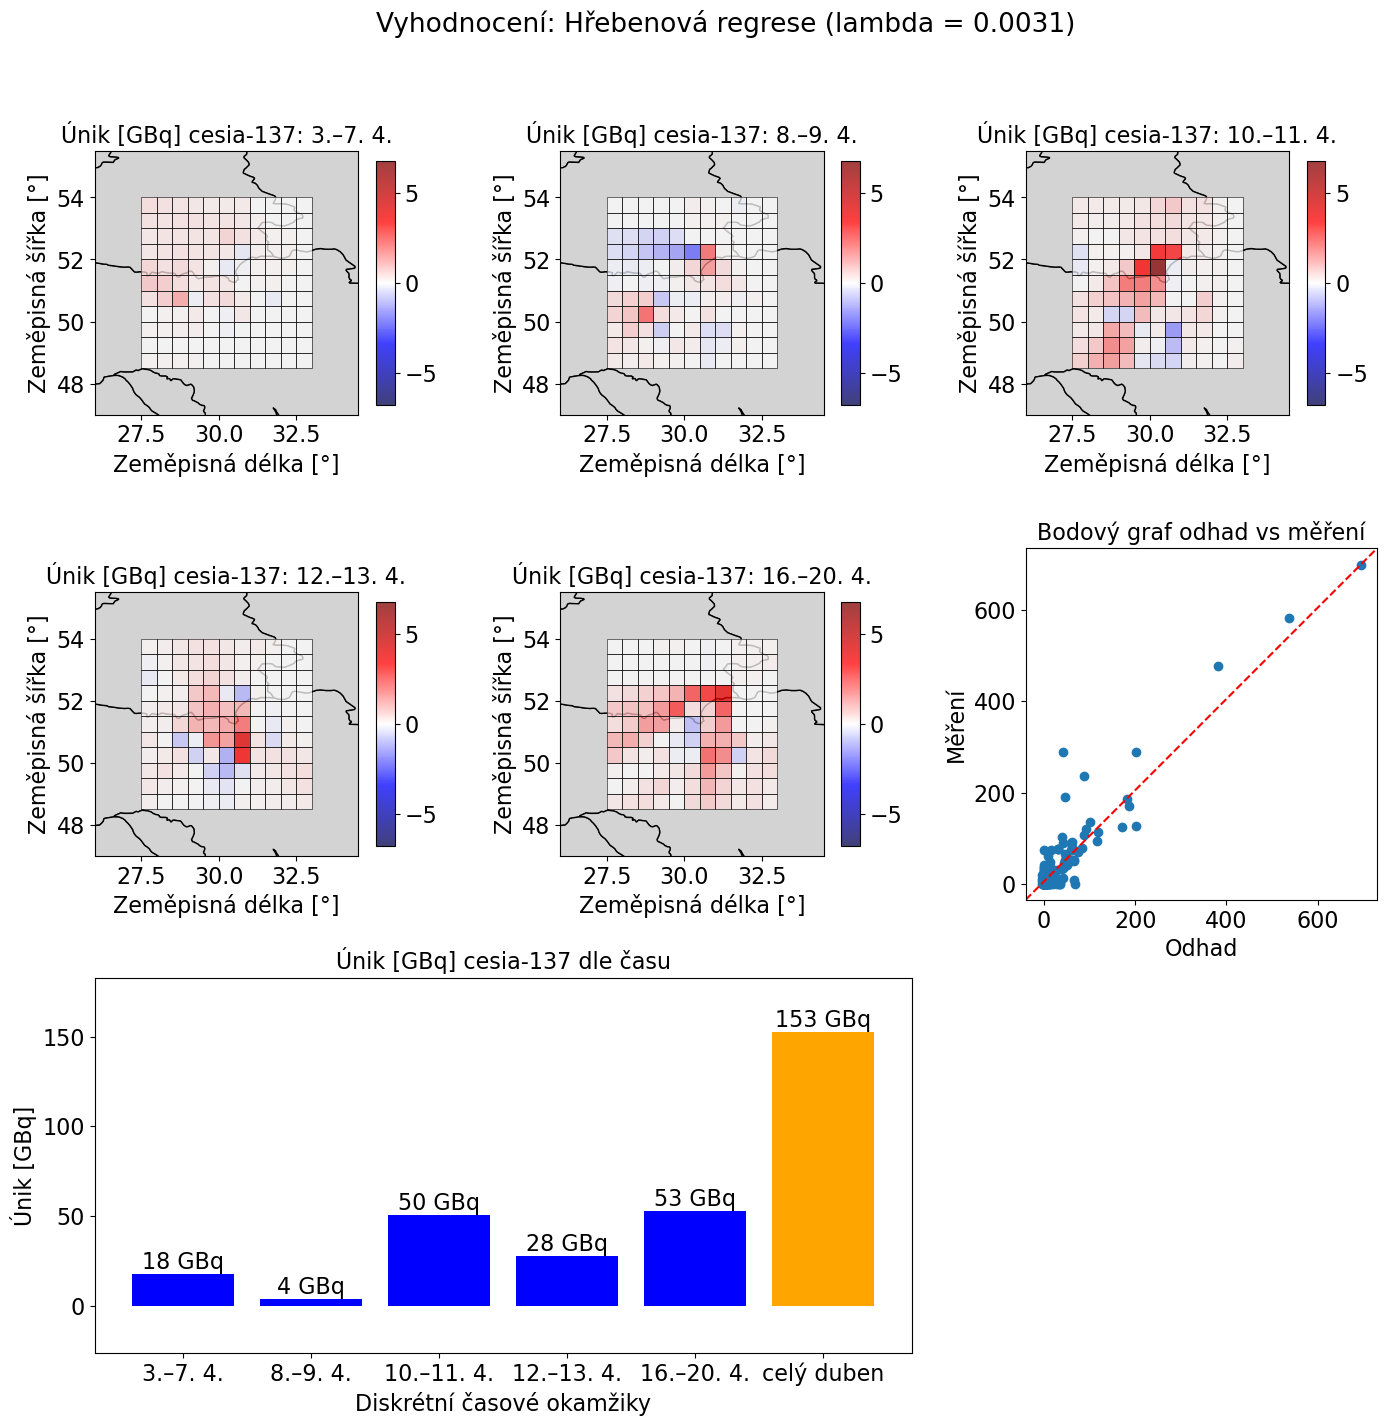

In [66]:
titleModel=f"Hřebenová regrese (lambda = {ridgeRegressionModelCrossValidation.alpha_})"
titleFile="RidgeRegression"
multiplot(betaHatRidge, titleModel, titleFile, scaleKoefBq=True)

## LASSO

In [69]:
from sklearn.linear_model import LassoCV

# skrytí varování spojitých s problémem konvergence
import warnings
warnings.filterwarnings('ignore')


alphasRange = [*np.arange(0.0001,1,0.001)]+[*np.arange(1.01,5,0.01)]+[*np.arange(6,16,0.1)]+[*np.arange(17,100,5)]
lassoModelCrossValidation = LassoCV(alphas = alphasRange, fit_intercept=False).fit(matrixX, y.reshape(-1))

betaHatLASSO = lassoModelCrossValidation.coef_.reshape(-1,1)

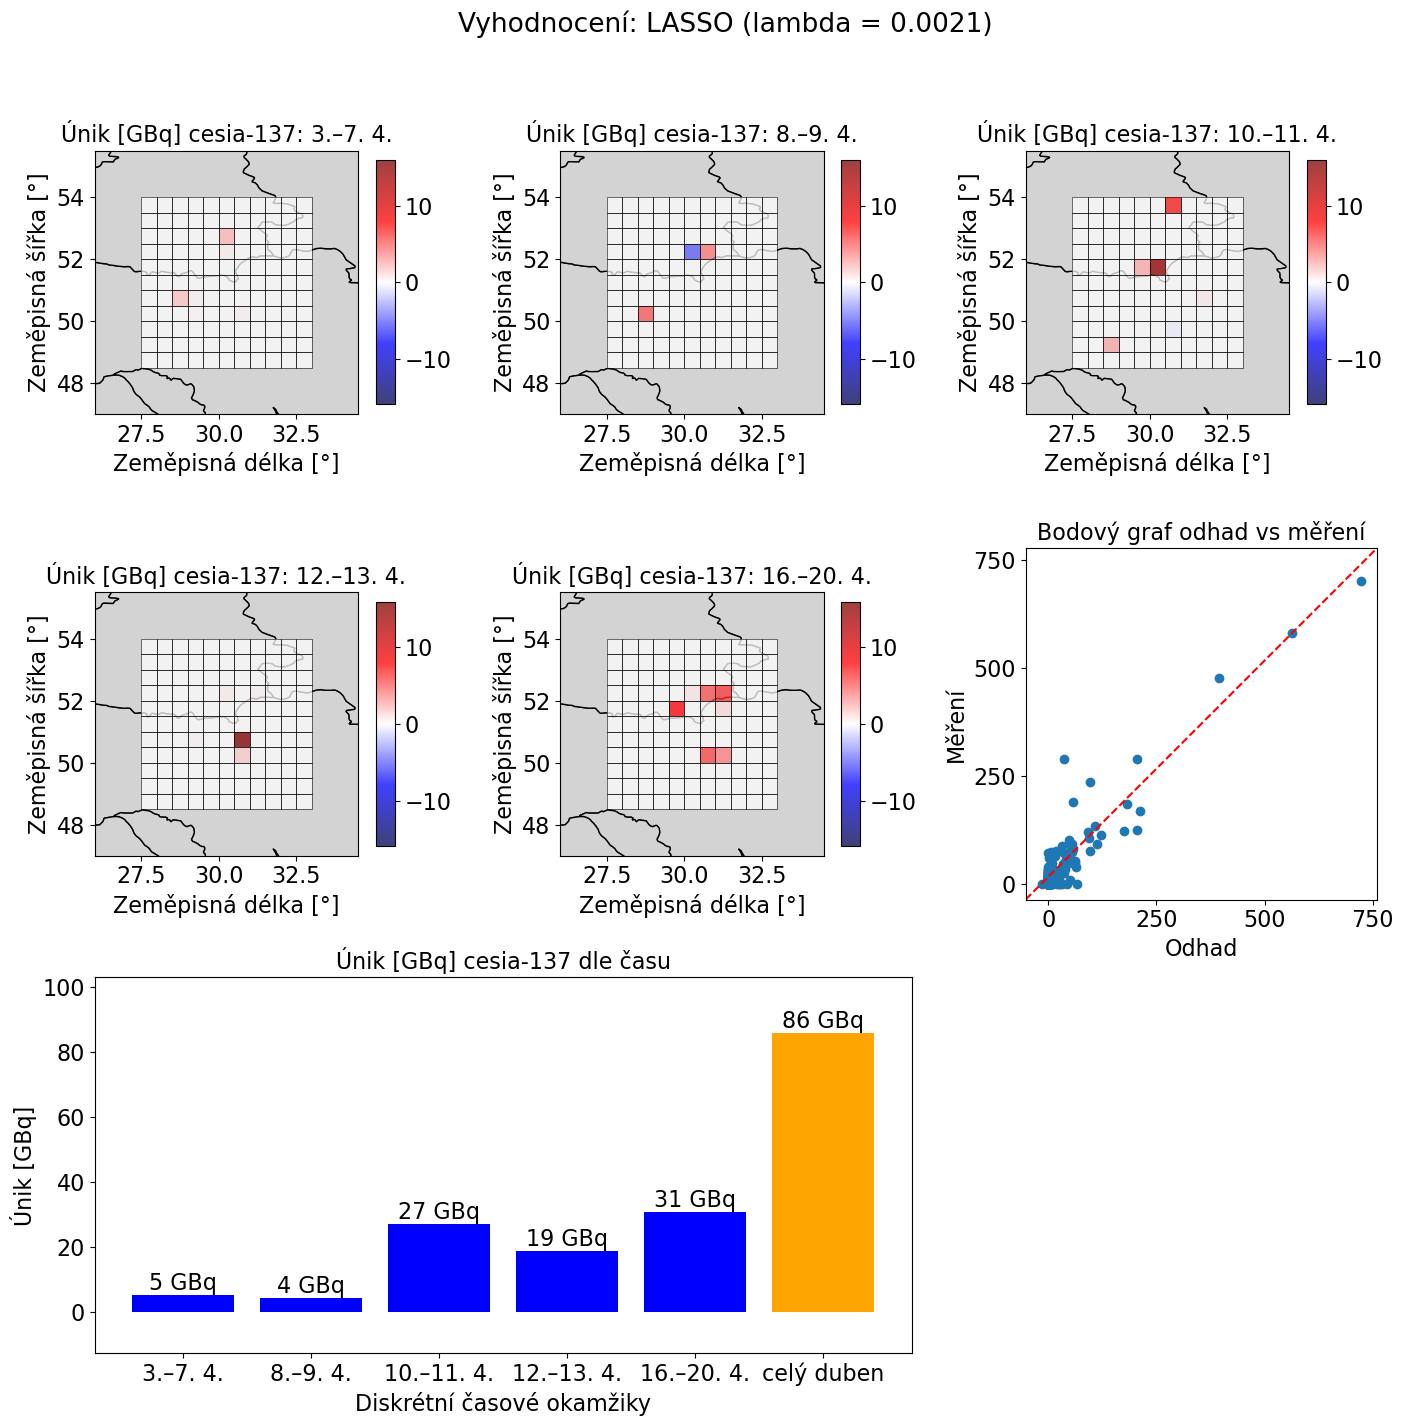

In [70]:
titleModel=f"LASSO (lambda = {lassoModelCrossValidation.alpha_})"
titleFile="LASSORegression"
multiplot(betaHatLASSO, titleModel, titleFile, scaleKoefBq=True)